In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')

# Set visualization style for better-looking plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Confirm successful import
print("=" * 70)
print("✅ ALL LIBRARIES IMPORTED SUCCESSFULLY!")
print("=" * 70)
print("\nLibraries loaded:")
print("  • NumPy version:", np.__version__)
print("  • Pandas version:", pd.__version__)
print("  • Scikit-learn: Ready for PCA and K-Means")
print("  • Matplotlib & Seaborn: Ready for visualizations")
print("\n" + "=" * 70)

✅ ALL LIBRARIES IMPORTED SUCCESSFULLY!

Libraries loaded:
  • NumPy version: 2.1.3
  • Pandas version: 2.2.3
  • Scikit-learn: Ready for PCA and K-Means
  • Matplotlib & Seaborn: Ready for visualizations



In [2]:
# ==============================================================
#  STEP 1.1 — Define Token List and Time Period (UPDATED)
# ==============================================================

import datetime as dt

tokens = [
    "BTC-USD","ETH-USD","BNB-USD","SOL-USD","XRP-USD","ADA-USD","AVAX-USD","DOT-USD","LINK-USD","MATIC-USD",
    "UNI-USD","AAVE-USD","ATOM-USD","NEAR-USD","DOGE-USD","LTC-USD","TRX-USD","ICP-USD","FIL-USD","SAND-USD",
    "MANA-USD","XLM-USD","ETC-USD","EGLD-USD","CAKE-USD","RUNE-USD","FTM-USD","SNX-USD","CRV-USD","MKR-USD",
    "1INCH-USD","FLOW-USD","DYDX-USD","OP-USD","AR-USD","ENS-USD","BAT-USD","CHZ-USD","QTUM-USD","WAVES-USD",
    "YFI-USD","XTZ-USD","KAVA-USD","RPL-USD","LRC-USD","ZIL-USD","ALGO-USD","VET-USD","THETA-USD","ZEC-USD"
]

end_date = dt.date.today()
start_date = end_date - dt.timedelta(days=730)

print(f"📆 Time period: {start_date}  →  {end_date}")
print(f"📊 Number of tokens: {len(tokens)}")



📆 Time period: 2023-11-03  →  2025-11-02
📊 Number of tokens: 50


In [3]:
# ==============================================================
#  STEP 1.2 — Download Daily Prices for Selected Tokens
# ==============================================================

import yfinance as yf

# Κατεβάζουμε ημερήσια δεδομένα για όλα τα tokens
# columns: Date | BTC-USD | ETH-USD | ... 
data = yf.download(
    tickers=tokens,
    start=start_date,
    end=end_date,
    interval='1d',
    group_by='ticker',
    auto_adjust=True,
    threads=True
)

print("✅ Data download complete!")


[*********************100%***********************]  50 of 50 completed

✅ Data download complete!


In [4]:
# ==============================================================
#  STEP 1.3 — Extract Close Prices and Clean the Dataset
# ==============================================================

# Δημιουργούμε DataFrame μόνο με τις τιμές κλεισίματος
close_prices = pd.DataFrame()

for token in tokens:
    try:
        # Κάθε token είναι ένα επίπεδο του MultiIndex
        close_prices[token] = data[token]['Close']
    except Exception as e:
        print(f"⚠️ Missing data for {token}: {e}")

# Εμφάνιση βασικής δομής
print("🔍 Initial shape (before cleaning):", close_prices.shape)

# Αφαίρεση tokens με πολλά NaN (>10% missing)
min_non_null = int(0.90 * len(close_prices))
tokens_to_keep = [t for t in close_prices.columns if close_prices[t].notna().sum() >= min_non_null]
tokens_dropped = [t for t in close_prices.columns if t not in tokens_to_keep]

close_prices = close_prices[tokens_to_keep]

# Συμπλήρωση μικρών κενών (π.χ. από μη trading days)
close_prices = close_prices.ffill().bfill()

print("✅ Cleaned close price dataset created successfully!")
print("📊 Final shape:", close_prices.shape)
print(f"🧱 Tokens kept: {len(tokens_to_keep)} | 🗑️ Dropped: {len(tokens_dropped)}")

# Έλεγχος για NaN
print("🧮 Remaining NaNs:", int(close_prices.isna().sum().sum()))

# Έλεγχος εύρους ημερομηνιών
print("📆 Date range:", close_prices.index.min().date(), "→", close_prices.index.max().date())

# Εμφάνιση πρώτων γραμμών
display(close_prices.head())


🔍 Initial shape (before cleaning): (730, 50)
✅ Cleaned close price dataset created successfully!
📊 Final shape: (730, 47)
🧱 Tokens kept: 47 | 🗑️ Dropped: 3
🧮 Remaining NaNs: 0
📆 Date range: 2023-11-03 → 2025-11-01


,BTC-USD,ETH-USD,BNB-USD,SOL-USD,XRP-USD,ADA-USD,AVAX-USD,DOT-USD,LINK-USD,AAVE-USD,...,YFI-USD,XTZ-USD,KAVA-USD,RPL-USD,LRC-USD,ZIL-USD,ALGO-USD,VET-USD,THETA-USD,ZEC-USD
Date,,,,,,,,,,,,,,,,,,,,,
2023-11-03,34732.324219,1832.795166,230.605972,39.519760,0.613002,0.329021,12.111171,4.615494,11.484773,90.105553,...,5677.854980,0.782406,0.675010,23.593542,0.216615,0.019532,0.111732,0.019277,0.754900,27.637583
2023-11-04,35082.195312,1857.698608,237.454605,42.346596,0.616184,0.328542,12.217773,4.691026,11.497036,90.149910,...,5753.724609,0.789520,0.696361,24.188173,0.214436,0.020233,0.114809,0.020304,0.774034,28.210516
2023-11-05,35049.355469,1894.157715,244.322479,41.238602,0.661147,0.342870,12.366694,4.773220,12.227702,89.236435,...,5970.510254,0.809671,0.734285,25.297543,0.221679,0.020418,0.121646,0.020554,0.793205,28.681141
2023-11-06,35037.371094,1899.837402,254.634796,42.128590,0.715517,0.363408,13.081213,4.968373,13.009284,99.354324,...,6144.944824,0.831423,0.751278,25.629305,0.228664,0.021060,0.129212,0.021755,0.818602,29.788086
2023-11-07,35443.562500,1888.124268,246.395294,43.092545,0.686402,0.351571,12.823540,4.931488,13.068293,97.577400,...,5971.139160,0.838795,0.736445,26.103655,0.225012,0.020670,0.123785,0.021695,0.827893,29.270014


In [5]:
# ==============================================================
#  STEP 1.4 — FEATURE ENGINEERING (REAL DEFI DATA)
# ==============================================================

from scipy.stats import skew, kurtosis

# --- 1️⃣ Υπολογίζουμε ημερήσιες αποδόσεις (%)
returns = close_prices.pct_change().dropna()

# --- 2️⃣ Υπολογίζουμε το reference token (BTC)
btc_returns = returns['BTC-USD']

# --- 3️⃣ Δημιουργούμε πίνακα με τα 8 χαρακτηριστικά ανά token
feature_data = []

for token in returns.columns:
    r = returns[token].dropna()
    mean_ret = r.mean()
    vol = r.std()
    sharpe = mean_ret / vol if vol != 0 else np.nan
    downside_vol = r[r < 0].std()
    
    # Υπολογισμός μέγιστου drawdown
    cumulative = (1 + r).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    max_dd = drawdown.min()
    
    corr_btc = r.corr(btc_returns)
    skw = skew(r)
    krt = kurtosis(r, fisher=True)
    
    feature_data.append([
        mean_ret, vol, sharpe, downside_vol,
        max_dd, corr_btc, skw, krt
    ])

# --- 4️⃣ Δημιουργούμε DataFrame
defi_data = pd.DataFrame(
    feature_data,
    columns=[
        'Mean_Return', 'Volatility', 'Sharpe_Ratio',
        'Downside_Vol', 'Max_Drawdown', 'Corr_BTC',
        'Skewness', 'Kurtosis'
    ],
    index=returns.columns
)

# --- 5️⃣ Καθαρίζουμε πιθανά NaNs
defi_data = defi_data.replace([np.inf, -np.inf], np.nan).dropna()

print("✅ Feature engineering completed successfully!")
print(f"📊 Shape: {defi_data.shape[0]} tokens × {defi_data.shape[1]} features")
display(defi_data.head())

# --- 6️⃣ Στατιστική περίληψη
print("\n📈 Statistical summary of features:")
display(defi_data.describe().round(4))

✅ Feature engineering completed successfully!
📊 Shape: 47 tokens × 8 features


,Mean_Return,Volatility,Sharpe_Ratio,Downside_Vol,Max_Drawdown,Corr_BTC,Skewness,Kurtosis
BTC-USD,0.001899,0.025246,0.075235,0.016044,-0.281445,1.000000,0.403592,2.329443
ETH-USD,0.001683,0.036484,0.046122,0.023018,-0.637877,0.779785,0.676379,4.374549
BNB-USD,0.002565,0.029384,0.087299,0.018979,-0.346023,0.605123,0.563118,4.115277
SOL-USD,0.003210,0.046818,0.068573,0.027223,-0.597081,0.718174,0.475539,2.621533
XRP-USD,0.002850,0.043598,0.065374,0.026596,-0.455967,0.565169,1.404157,9.408462



📈 Statistical summary of features:


,Mean_Return,Volatility,Sharpe_Ratio,Downside_Vol,Max_Drawdown,Corr_BTC,Skewness,Kurtosis
count,47.0000,47.0000,47.0000,47.0000,47.0000,47.0000,47.0000,47.0000
mean,0.0011,0.0493,0.0235,0.0308,-0.7343,0.6120,1.0052,16.0118
std,0.0013,0.0081,0.0280,0.0049,0.1497,0.1090,2.2997,47.8657
min,-0.0017,0.0252,-0.0317,0.0160,-0.9325,0.2144,-1.7663,1.9875
25%,0.0001,0.0449,0.0021,0.0287,-0.8464,0.5625,0.1553,3.5924
50%,0.0010,0.0488,0.0197,0.0313,-0.7511,0.6127,0.4755,4.7850
75%,0.0020,0.0538,0.0400,0.0332,-0.6561,0.6566,0.8700,8.2953
max,0.0053,0.0658,0.0907,0.0426,-0.2814,1.0000,14.6266,328.6582


In [6]:
class SimplePCA:
    """
    Principal Component Analysis for DeFi Portfolio Analysis
    
    This class wraps sklearn's PCA with helpful methods for:
    - Fitting PCA to DeFi data
    - Transforming data to PC space
    - Analyzing variance explained
    - Visualizing results
    - Interpreting component loadings
    """
    
    def __init__(self, n_components=None):
        """
        Initialize PCA
        
        Parameters:
        -----------
        n_components : int or None
            Number of components to keep
            - None = keep all components
            - int = keep specific number (e.g., 5)
            - Tip: Start with None to see all, then choose optimal number
        """
        self.n_components = n_components
        self.scaler = StandardScaler()  # For standardizing features
        self.pca = None  # Will hold the fitted PCA model
        self.feature_names = None  # To remember original feature names
        
    def fit(self, X, feature_names=None):
        """
        Fit PCA model to data
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Data matrix (e.g., 50 tokens × 8 features)
        feature_names : list of str, optional
            Names of features for better interpretation
        
        Returns:
        --------
        self : object
            Returns self for method chaining
        """
        # Step 1: Standardize features (VERY IMPORTANT!)
        # This ensures all features have mean=0 and std=1
        X_scaled = self.scaler.fit_transform(X)
        
        # Step 2: Fit PCA
        self.pca = PCA(n_components=self.n_components)
        self.pca.fit(X_scaled)
        
        # Step 3: Save feature names for later use
        self.feature_names = feature_names
        
        # Print summary
        print(f"\n✅ PCA fitted successfully!")
        print(f"   Components: {self.pca.n_components_}")
        print(f"   Total variance explained: {self.pca.explained_variance_ratio_.sum():.2%}")
        
        return self
    
    def transform(self, X):
        """
        Transform data to principal component space
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Data to transform
        
        Returns:
        --------
        X_transformed : array, shape (n_samples, n_components)
            Data in PC space
        """
        X_scaled = self.scaler.transform(X)
        return self.pca.transform(X_scaled)
    
    def fit_transform(self, X, feature_names=None):
        """
        Fit PCA and transform data in one step
        
        This is a convenience method that combines fit() and transform()
        """
        self.fit(X, feature_names)
        return self.transform(X)
    
    def inverse_transform(self, X_pca):
        """
        Reconstruct original features from principal components
        
        Useful for understanding what PCs represent
        """
        X_scaled = self.pca.inverse_transform(X_pca)
        return self.scaler.inverse_transform(X_scaled)
    
    def get_variance_summary(self):
        """
        Get detailed variance statistics for each component
        
        Returns:
        --------
        DataFrame with columns:
        - PC: Component name (PC1, PC2, ...)
        - Variance_Explained: Proportion of variance (0 to 1)
        - Cumulative_Variance: Running total of variance
        - Eigenvalue: The actual eigenvalue (variance in that direction)
        """
        var_exp = self.pca.explained_variance_ratio_
        cum_var = np.cumsum(var_exp)
        
        df = pd.DataFrame({
            'PC': [f'PC{i+1}' for i in range(len(var_exp))],
            'Variance_Explained': var_exp,
            'Cumulative_Variance': cum_var,
            'Eigenvalue': self.pca.explained_variance_
        })
        
        return df
    
    def get_loadings(self):
        """
        Get feature loadings (how features relate to PCs)
        
        Loadings tell us:
        - Which features contribute most to each PC
        - Direction of relationship (positive or negative)
        
        Returns:
        --------
        DataFrame with features as rows, PCs as columns
        
        Interpretation:
        - High positive loading: Feature increases with PC
        - High negative loading: Feature decreases with PC  
        - Near-zero loading: Feature unrelated to PC
        """
        loadings = pd.DataFrame(
            self.pca.components_.T,
            columns=[f'PC{i+1}' for i in range(self.pca.n_components_)],
            index=self.feature_names if self.feature_names else range(self.pca.n_components_)
        )
        return loadings
    
    def plot_scree(self, figsize=(14, 5)):
        """
        Create scree plot to help choose optimal number of components
        
        The scree plot shows:
        - Left: Variance per component (look for "elbow")
        - Right: Cumulative variance (aim for 80-90%)
        """
        var_summary = self.get_variance_summary()
        
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        
        # Left plot: Scree Plot
        axes[0].bar(var_summary['PC'], var_summary['Variance_Explained'], 
                    alpha=0.7, color='steelblue')
        axes[0].plot(var_summary['PC'], var_summary['Variance_Explained'], 
                     'ro-', linewidth=2, markersize=8)
        axes[0].set_xlabel('Principal Component', fontsize=12)
        axes[0].set_ylabel('Variance Explained', fontsize=12)
        axes[0].set_title('Scree Plot\n(Look for the "elbow")', 
                         fontsize=13, fontweight='bold')
        axes[0].grid(True, alpha=0.3)
        axes[0].tick_params(axis='x', rotation=45)
        
        # Right plot: Cumulative Variance
        axes[1].plot(var_summary['PC'], var_summary['Cumulative_Variance'], 
                     'bo-', linewidth=2, markersize=8)
        axes[1].axhline(y=0.80, color='green', linestyle='--', 
                        linewidth=2, label='80% threshold')
        axes[1].axhline(y=0.90, color='orange', linestyle='--', 
                        linewidth=2, label='90% threshold')
        axes[1].set_xlabel('Number of Components', fontsize=12)
        axes[1].set_ylabel('Cumulative Variance Explained', fontsize=12)
        axes[1].set_title('Cumulative Variance Explained', 
                         fontsize=13, fontweight='bold')
        axes[1].legend(fontsize=10)
        axes[1].grid(True, alpha=0.3)
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].set_ylim([0, 1.05])
        
        plt.tight_layout()
        return fig
    
    def plot_loadings(self, n_components=3, n_top_features=10, figsize=(15, 5)):
        """
        Visualize feature loadings for top components
        
        Shows which features are most important for each PC
        
        Parameters:
        -----------
        n_components : int
            Number of PCs to display (default: 3)
        n_top_features : int
            How many features to show per PC (default: 10)
        """
        loadings = self.get_loadings()
        n_components = min(n_components, loadings.shape[1])
        
        fig, axes = plt.subplots(1, n_components, figsize=figsize)
        if n_components == 1:
            axes = [axes]
        
        for i in range(n_components):
            pc_col = f'PC{i+1}'
            
            # Get top features by absolute loading
            top_features = loadings[pc_col].abs().nlargest(n_top_features)
            sorted_loadings = loadings.loc[top_features.index, pc_col].sort_values()
            
            # Color code: red=negative, green=positive
            colors = ['red' if x < 0 else 'green' for x in sorted_loadings.values]
            
            axes[i].barh(range(len(sorted_loadings)), sorted_loadings.values, 
                        color=colors, alpha=0.7)
            axes[i].set_yticks(range(len(sorted_loadings)))
            axes[i].set_yticklabels(sorted_loadings.index, fontsize=9)
            axes[i].set_xlabel('Loading', fontsize=11)
            axes[i].set_title(f'{pc_col}\n({self.pca.explained_variance_ratio_[i]:.1%} variance)', 
                            fontsize=12, fontweight='bold')
            axes[i].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
            axes[i].grid(True, alpha=0.3, axis='x')
        
        plt.tight_layout()
        return fig

print("=" * 70)
print("✅ SimplePCA class created successfully!")
print("=" * 70)
print("\nAvailable methods:")
print("  • fit(X, feature_names) - Fit PCA to data")
print("  • transform(X) - Transform data to PC space")
print("  • fit_transform(X, feature_names) - Fit and transform in one step")
print("  • get_variance_summary() - Get variance statistics")
print("  • get_loadings() - Get feature loadings")
print("  • plot_scree() - Visualize variance explained")
print("  • plot_loadings() - Visualize feature importance")
#print("\n👉 Next: We'll generate some synthetic DeFi data to practice with")
print("=" * 70)

✅ SimplePCA class created successfully!

Available methods:
  • fit(X, feature_names) - Fit PCA to data
  • transform(X) - Transform data to PC space
  • fit_transform(X, feature_names) - Fit and transform in one step
  • get_variance_summary() - Get variance statistics
  • get_loadings() - Get feature loadings
  • plot_scree() - Visualize variance explained
  • plot_loadings() - Visualize feature importance


In [7]:
# ==============================================================
#  PART 1.2 — PCA FITTING AND VARIANCE ANALYSIS
# ==============================================================

print("=" * 70)
print("FITTING PCA TO DEFI PORTFOLIO DATA")
print("=" * 70)

# Initialize PCA with 5 components (reasonable starting point)
print("\n🔧 Initializing PCA model...")
print("   Setting n_components=5 (keeping 5 out of 8 dimensions)")

pca_model = SimplePCA(n_components=5)

# Fit PCA and transform data
print("\n⚙️  Fitting PCA and transforming data...")
X_pca = pca_model.fit_transform(
    defi_data.values,
    feature_names=defi_data.columns.tolist()
)

print("\n" + "=" * 70)
print("TRANSFORMATION COMPLETE!")
print("=" * 70)

# Dimensionality summary
print(f"\n📊 Dimensionality Reduction:")
print(f"   Original shape: {defi_data.shape[0]} tokens × {defi_data.shape[1]} features")
print(f"   Reduced shape:  {X_pca.shape[0]} tokens × {X_pca.shape[1]} components")
print(f"   Reduction: {defi_data.shape[1]} → {X_pca.shape[1]} dimensions")
print(f"   Space savings: {(1 - X_pca.shape[1]/defi_data.shape[1])*100:.1f}% fewer dimensions!")

# Variance summary
variance_summary = pca_model.get_variance_summary()
print(f"\n📈 Variance Explained by Each Component:")
display(variance_summary.round(4))

# Highlight key insights
total_var = variance_summary['Cumulative_Variance'].iloc[-1]
pc1_var = variance_summary['Variance_Explained'].iloc[0]
pc2_var = variance_summary['Variance_Explained'].iloc[1]
pc3_var = variance_summary['Variance_Explained'].iloc[2]

print("\n🔍 Key Insights:")
print(f"   • PC1 captures {pc1_var:.1%} of total variation")
print(f"   • PC1 + PC2 capture {variance_summary['Cumulative_Variance'].iloc[1]:.1%}")
print(f"   • First 3 PCs capture {variance_summary['Cumulative_Variance'].iloc[2]:.1%}")
print(f"   • All 5 PCs capture {total_var:.1%} of total variance")

# Interpretation guidance
if total_var >= 0.90:
    print(f"\n✅ Excellent! {total_var:.1%} variance retained with just 5 components.")
elif total_var >= 0.80:
    print(f"\n✅ Good! {total_var:.1%} variance retained — acceptable for most applications.")
else:
    print(f"\n⚠️  Only {total_var:.1%} variance retained — might need more components.")

# Preview of transformed data
print(f"\n📋 Sample of Transformed Data (PC space):")
X_pca_df = pd.DataFrame(
    X_pca[:5],
    columns=[f'PC{i+1}' for i in range(X_pca.shape[1])],
    index=defi_data.index[:5]
)
display(X_pca_df.round(3))

print("\n💡 Each row = a token; each column = its score in a principal component.")
print("=" * 70)
print("✅ PCA fitting complete! Data successfully transformed.")
print("=" * 70)

FITTING PCA TO DEFI PORTFOLIO DATA

🔧 Initializing PCA model...
   Setting n_components=5 (keeping 5 out of 8 dimensions)

⚙️  Fitting PCA and transforming data...

✅ PCA fitted successfully!
   Components: 5
   Total variance explained: 98.83%

TRANSFORMATION COMPLETE!

📊 Dimensionality Reduction:
   Original shape: 47 tokens × 8 features
   Reduced shape:  47 tokens × 5 components
   Reduction: 8 → 5 dimensions
   Space savings: 37.5% fewer dimensions!

📈 Variance Explained by Each Component:


,PC,Variance_Explained,Cumulative_Variance,Eigenvalue
0,PC1,0.4692,0.4692,3.8352
1,PC2,0.2937,0.7629,2.4010
2,PC3,0.1638,0.9267,1.3386
3,PC4,0.0433,0.9700,0.3536
4,PC5,0.0184,0.9883,0.1501



🔍 Key Insights:
   • PC1 captures 46.9% of total variation
   • PC1 + PC2 capture 76.3%
   • First 3 PCs capture 92.7%
   • All 5 PCs capture 98.8% of total variance

✅ Excellent! 98.8% variance retained with just 5 components.

📋 Sample of Transformed Data (PC space):


,PC1,PC2,PC3,PC4,PC5
BTC-USD,4.202,4.764,-1.367,1.429,0.087
ETH-USD,1.740,2.157,-0.664,0.530,-0.555
BNB-USD,4.291,2.294,-0.284,-1.253,0.101
SOL-USD,1.969,1.377,1.307,0.514,-0.046
XRP-USD,2.687,0.675,0.796,-0.699,0.471



💡 Each row = a token; each column = its score in a principal component.
✅ PCA fitting complete! Data successfully transformed.


VISUALIZING VARIANCE EXPLAINED - SCREE PLOT

📊 Creating scree plot to determine optimal number of components...
   This will help us decide: 'How many PCs should we keep?'



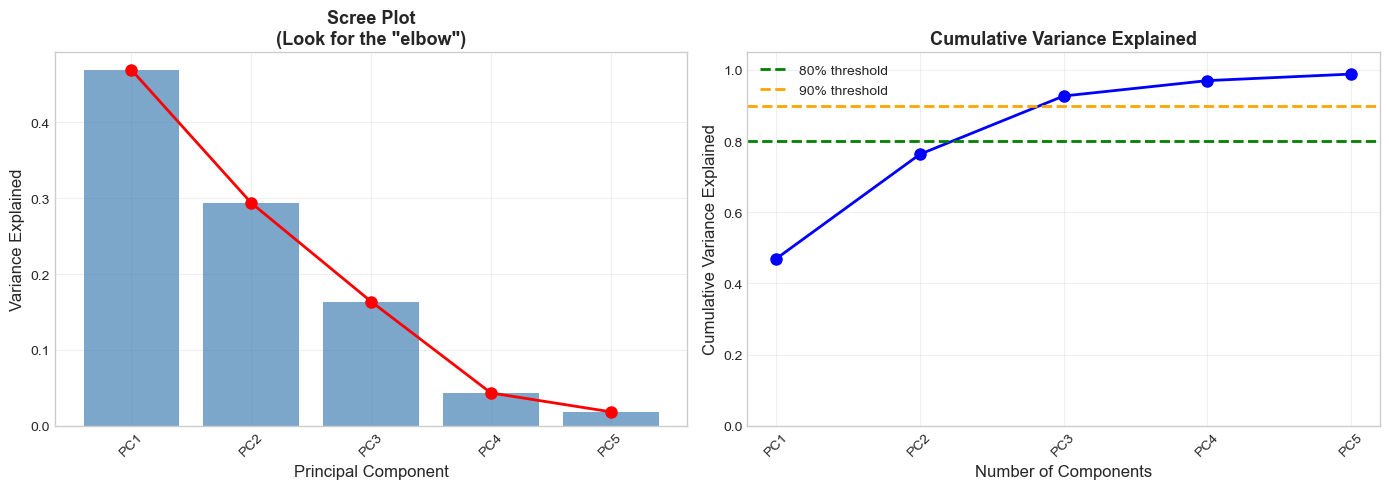


INTERPRETING THE SCREE PLOT

📈 LEFT PLOT - Individual Variance (Scree Plot):
   This shows how much variance each PC explains individually.

   • PC1 explains: 46.9% ← Most important!
   • PC2 explains: 29.4%
   • PC3 explains: 16.4%

   💡 PC1 dominates with 46.9%!
      This suggests ONE main factor drives variation in our portfolio
      (Likely 'size': Market Cap + TVL + Volume)

   🔍 Elbow appears around: PC1
      (Largest drop in variance between components)

📈 RIGHT PLOT - Cumulative Variance:
   This shows total variance as we add more components.

   • To explain 80% variance: Need 3 components
   • To explain 90% variance: Need 3 components
   • Our 5 components explain: 98.8%

RECOMMENDATION

✅ OPTIMAL NUMBER OF COMPONENTS: 3
   Reason: First 3 PCs capture sufficient variance (>80%)
   Variance explained: 92.7%
   Dimensionality reduction: 8 → 3 (38% of original)

📊 Summary Statistics:


,Metric,Value
0,Original Features,8
1,Optimal PCs,3
2,Variance Retained,92.7%
3,Information Lost,7.3%
4,Compression Ratio,2.7x



💡 What this means:
   • We can represent our portfolio with just 3 numbers per token
   • Instead of tracking 8 features, we track 3 principal components
   • We keep 92.7% of the information
   • We lose only 7.3% of the information

🎯 Next Steps:
   1. Examine component loadings (which features contribute to each PC)
   2. Interpret what each PC represents
   3. Name the PCs based on their loadings



In [8]:
print("=" * 70)
print("VISUALIZING VARIANCE EXPLAINED - SCREE PLOT")
print("=" * 70)

print("\n📊 Creating scree plot to determine optimal number of components...")
print("   This will help us decide: 'How many PCs should we keep?'\n")

# Create the scree plot
fig = pca_model.plot_scree(figsize=(14, 5))
plt.show()

print("\n" + "=" * 70)
print("INTERPRETING THE SCREE PLOT")
print("=" * 70)

# Get variance data for analysis
variance_summary = pca_model.get_variance_summary()

# Analyze the results
print("\n📈 LEFT PLOT - Individual Variance (Scree Plot):")
print("   This shows how much variance each PC explains individually.")
print()

# Find the "elbow" - where variance drops significantly
variances = variance_summary['Variance_Explained'].values
var_diffs = np.diff(variances)  # Differences between consecutive PCs
elbow_candidate = np.argmax(np.abs(var_diffs)) + 1  # +1 because diff reduces array size

print(f"   • PC1 explains: {variances[0]:.1%} ← Most important!")
print(f"   • PC2 explains: {variances[1]:.1%}")
print(f"   • PC3 explains: {variances[2]:.1%}")

if variances[0] > 0.40:
    print(f"\n   💡 PC1 dominates with {variances[0]:.1%}!")
    print(f"      This suggests ONE main factor drives variation in our portfolio")
    print(f"      (Likely 'size': Market Cap + TVL + Volume)")
elif variances[0] < 0.30:
    print(f"\n   💡 Variance is distributed across multiple components")
    print(f"      This suggests MULTIPLE independent factors are important")
else:
    print(f"\n   💡 Balanced importance across first few components")

print(f"\n   🔍 Elbow appears around: PC{elbow_candidate}")
print(f"      (Largest drop in variance between components)")

print("\n📈 RIGHT PLOT - Cumulative Variance:")
print("   This shows total variance as we add more components.")
print()

# Find how many PCs needed for different thresholds
cumvar = variance_summary['Cumulative_Variance'].values
n_80 = np.argmax(cumvar >= 0.80) + 1
n_90 = np.argmax(cumvar >= 0.90) + 1

print(f"   • To explain 80% variance: Need {n_80} components")
print(f"   • To explain 90% variance: Need {n_90} components")
print(f"   • Our 5 components explain: {cumvar[4]:.1%}")

print("\n" + "=" * 70)
print("RECOMMENDATION")
print("=" * 70)

# Make recommendation
if cumvar[2] >= 0.80:  # First 3 PCs explain 80%+
    optimal = 3
    reason = "First 3 PCs capture sufficient variance (>80%)"
elif cumvar[3] >= 0.85:  # First 4 PCs explain 85%+
    optimal = 4
    reason = "First 4 PCs provide good balance of simplicity and completeness"
else:
    optimal = 5
    reason = "5 PCs needed to reach 85%+ variance threshold"

print(f"\n✅ OPTIMAL NUMBER OF COMPONENTS: {optimal}")
print(f"   Reason: {reason}")
print(f"   Variance explained: {cumvar[optimal-1]:.1%}")
print(f"   Dimensionality reduction: {defi_data.shape[1]} → {optimal} ({optimal/defi_data.shape[1]*100:.0f}% of original)")

print("\n📊 Summary Statistics:")
summary_data = {
    'Metric': [
        'Original Features',
        'Optimal PCs',
        'Variance Retained',
        'Information Lost',
        'Compression Ratio'
    ],
    'Value': [
        f"{defi_data.shape[1]}",
        f"{optimal}",
        f"{cumvar[optimal-1]:.1%}",
        f"{(1-cumvar[optimal-1]):.1%}",
        f"{defi_data.shape[1]/optimal:.1f}x"
    ]
}
summary_df = pd.DataFrame(summary_data)
display(summary_df)

print("\n💡 What this means:")
print(f"   • We can represent our portfolio with just {optimal} numbers per token")
print(f"   • Instead of tracking 8 features, we track {optimal} principal components")
print(f"   • We keep {cumvar[optimal-1]:.1%} of the information")
print(f"   • We lose only {(1-cumvar[optimal-1]):.1%} of the information")

print("\n🎯 Next Steps:")
print("   1. Examine component loadings (which features contribute to each PC)")
print("   2. Interpret what each PC represents")
print("   3. Name the PCs based on their loadings")
print("\n" + "=" * 70)

ANALYZING PRINCIPAL COMPONENT LOADINGS

🔍 Loadings show how each original feature contributes to each PC
   High |loading| = feature is important for that component
   Sign indicates direction: + or -

📊 LOADINGS MATRIX:
   (Rows = Features, Columns = Principal Components)


,PC1,PC2,PC3,PC4,PC5
Mean_Return,0.386,-0.011,0.570,0.033,-0.051
Volatility,-0.263,-0.369,0.532,0.288,-0.169
Sharpe_Ratio,0.446,0.092,0.413,0.045,-0.006
Downside_Vol,-0.443,-0.191,0.266,0.089,0.730
Max_Drawdown,0.468,0.206,-0.015,-0.101,0.596
Corr_BTC,-0.074,0.562,-0.054,0.820,0.014
Skewness,0.308,-0.484,-0.175,0.345,-0.134
Kurtosis,0.260,-0.476,-0.344,0.323,0.250



💡 How to read this table:
   • Values close to ±1.0 = STRONG relationship
   • Values close to ±0.5 = MODERATE relationship
   • Values close to 0.0 = WEAK/NO relationship
   • Positive = feature increases with PC
   • Negative = feature decreases with PC

INTERPRETING EACH PRINCIPAL COMPONENT

PC1 - 46.9% of variance

🔺 Top POSITIVE loadings (features that increase with PC1):
   Max_Drawdown         +0.468  █████████
   Sharpe_Ratio         +0.446  ████████
   Mean_Return          +0.386  ███████

🔻 Top NEGATIVE loadings (features that decrease with PC1):
   Downside_Vol         -0.443  ████████

💭 Interpretation Hint:
   No dominant features - might be capturing residual variance

PC2 - 29.4% of variance

🔺 Top POSITIVE loadings (features that increase with PC2):
   Corr_BTC             +0.562  ███████████

🔻 Top NEGATIVE loadings (features that decrease with PC2):
   Skewness             -0.484  █████████
   Kurtosis             -0.476  █████████
   Volatility           -0.369  ███

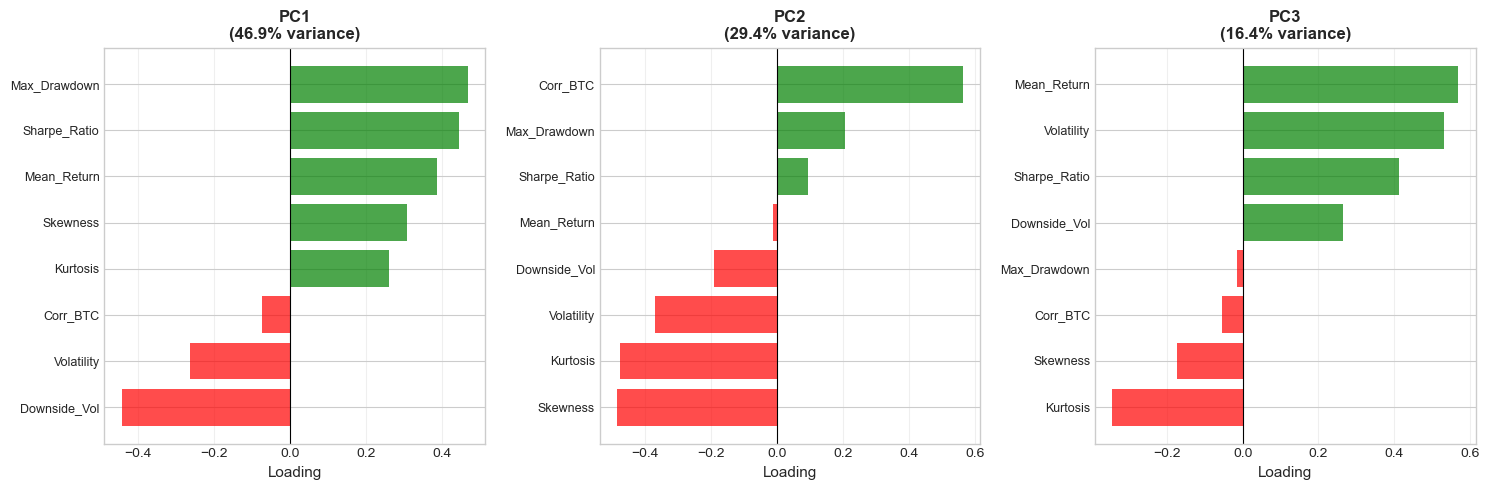


SUMMARY: NAMING OUR PRINCIPAL COMPONENTS


,Component,Variance,Top Features,Suggested Name
0,PC1,46.9%,"Max_Drawdown, Sharpe_Ratio, Downside_Vol",Mixed Factor
1,PC2,29.4%,"Corr_BTC, Skewness, Kurtosis",Mixed Factor
2,PC3,16.4%,"Mean_Return, Volatility, Sharpe_Ratio",Risk/Return Profile



💡 Using These Interpretations:
   • PC1 (Size): Select tokens across different size categories
   • PC2 (Risk): Balance high-risk and low-risk tokens
   • PC3 (Exposure): Diversify market exposure



In [9]:
print("=" * 70)
print("ANALYZING PRINCIPAL COMPONENT LOADINGS")
print("=" * 70)

print("\n🔍 Loadings show how each original feature contributes to each PC")
print("   High |loading| = feature is important for that component")
print("   Sign indicates direction: + or -\n")

# Get the loadings matrix
loadings = pca_model.get_loadings()

print("📊 LOADINGS MATRIX:")
print("   (Rows = Features, Columns = Principal Components)")
print("=" * 70)
display(loadings.round(3))

print("\n💡 How to read this table:")
print("   • Values close to ±1.0 = STRONG relationship")
print("   • Values close to ±0.5 = MODERATE relationship")
print("   • Values close to 0.0 = WEAK/NO relationship")
print("   • Positive = feature increases with PC")
print("   • Negative = feature decreases with PC")

# Analyze each PC
print("\n" + "=" * 70)
print("INTERPRETING EACH PRINCIPAL COMPONENT")
print("=" * 70)

for i in range(min(3, loadings.shape[1])):  # Analyze first 3 PCs
    pc_name = f'PC{i+1}'
    pc_loadings = loadings[pc_name]
    
    print(f"\n{'='*70}")
    print(f"{pc_name} - {pca_model.pca.explained_variance_ratio_[i]:.1%} of variance")
    print('='*70)
    
    # Get top positive and negative loadings
    top_positive = pc_loadings.nlargest(3)
    top_negative = pc_loadings.nsmallest(3)
    
    print(f"\n🔺 Top POSITIVE loadings (features that increase with {pc_name}):")
    for feature, loading in top_positive.items():
        if loading > 0.3:  # Only show meaningful loadings
            bar = '█' * int(abs(loading) * 20)
            print(f"   {feature:20s} {loading:+.3f}  {bar}")
    
    print(f"\n🔻 Top NEGATIVE loadings (features that decrease with {pc_name}):")
    for feature, loading in top_negative.items():
        if loading < -0.3:  # Only show meaningful loadings
            bar = '█' * int(abs(loading) * 20)
            print(f"   {feature:20s} {loading:+.3f}  {bar}")
    
    # Suggest interpretation
    print(f"\n💭 Interpretation Hint:")
    
    # Analyze dominant features
    abs_loadings = pc_loadings.abs()
    dominant_features = abs_loadings[abs_loadings > 0.5].sort_values(ascending=False)
    
    if len(dominant_features) > 0:
        print(f"   Strong loadings on: {', '.join(dominant_features.index.tolist())}")
        
        # Pattern matching for common DeFi factors
        if any(feat in dominant_features.index for feat in ['Market_Cap', 'TVL_USD', 'Volume_USD']):
            print(f"   → This looks like a SIZE/LIQUIDITY factor")
            print(f"   → Separates large established tokens from small new ones")
        
        if any(feat in dominant_features.index for feat in ['Volatility', 'Mean_Return']):
            print(f"   → This looks like a RISK/RETURN factor")
            print(f"   → Separates high-risk/high-return from stable tokens")
        
        if any(feat in dominant_features.index for feat in ['ETH_Correlation', 'Sentiment_Score']):
            print(f"   → This looks like a MARKET EXPOSURE factor")
            print(f"   → Separates market-following from independent tokens")
    else:
        print(f"   No dominant features - might be capturing residual variance")

print("\n" + "=" * 70)

# Create visual representation of loadings
print("\n📊 Creating loading visualizations...")
print("   Green bars = positive loadings (feature increases with PC)")
print("   Red bars = negative loadings (feature decreases with PC)")
print("   Length = strength of relationship\n")

fig = pca_model.plot_loadings(n_components=3, n_top_features=8, figsize=(15, 5))
plt.show()

print("\n" + "=" * 70)
print("SUMMARY: NAMING OUR PRINCIPAL COMPONENTS")
print("=" * 70)

# Create a summary table
pc_interpretations = []
for i in range(min(3, loadings.shape[1])):
    pc_name = f'PC{i+1}'
    variance = pca_model.pca.explained_variance_ratio_[i]
    
    # Get dominant features
    pc_loadings = loadings[pc_name]
    top_features = pc_loadings.abs().nlargest(3)
    
    # Suggest a name based on features
    feature_list = top_features.index.tolist()
    if any(f in feature_list for f in ['Market_Cap', 'TVL_USD', 'Volume_USD']):
        suggested_name = "Token Size/Liquidity"
    elif any(f in feature_list for f in ['Volatility', 'Mean_Return']):
        suggested_name = "Risk/Return Profile"
    elif any(f in feature_list for f in ['ETH_Correlation', 'Sentiment_Score']):
        suggested_name = "Market Exposure"
    else:
        suggested_name = "Mixed Factor"
    
    pc_interpretations.append({
        'Component': pc_name,
        'Variance': f"{variance:.1%}",
        'Top Features': ', '.join(feature_list),
        'Suggested Name': suggested_name
    })

interpretation_df = pd.DataFrame(pc_interpretations)
display(interpretation_df)

print("\n💡 Using These Interpretations:")
print("   • PC1 (Size): Select tokens across different size categories")
print("   • PC2 (Risk): Balance high-risk and low-risk tokens")
print("   • PC3 (Exposure): Diversify market exposure")

print("\n" + "=" * 70)

In [10]:
class SimpleKMeans:
    """
    K-Means Clustering for DeFi Portfolio Segmentation
    
    This class wraps sklearn's KMeans with helpful methods for:
    - Finding optimal number of clusters
    - Fitting K-Means to DeFi data
    - Analyzing cluster characteristics
    - Visualizing clusters
    - Interpreting results for portfolio decisions
    """
    
    def __init__(self, n_clusters=3, random_state=42):
        """
        Initialize K-Means
        
        Parameters:
        -----------
        n_clusters : int, default=3
            Number of clusters (k)
            - Start with 3-5 for portfolio segmentation
            - Use elbow method to find optimal value
        random_state : int, default=42
            Random seed for reproducibility
            - Same seed = same results every time
            - Important for comparing different runs
        """
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.scaler = StandardScaler()  # For standardizing features
        self.kmeans = None  # Will hold the fitted KMeans model
        self.feature_names = None  # To remember feature names
        
    def fit(self, X, feature_names=None):
        """
        Fit K-Means model to data
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Data matrix (e.g., 50 tokens × 8 features)
        feature_names : list of str, optional
            Names of features for interpretation
        
        Returns:
        --------
        self : object
            Returns self for method chaining
        """
        # Step 1: Standardize features (CRITICAL!)
        # Without this, features with large values dominate
        X_scaled = self.scaler.fit_transform(X)
        
        # Step 2: Fit K-Means
        self.kmeans = KMeans(
            n_clusters=self.n_clusters,
            random_state=self.random_state,
            n_init=10  # Run algorithm 10 times, keep best result
        )
        self.kmeans.fit(X_scaled)
        
        # Step 3: Save feature names
        self.feature_names = feature_names
        
        # Print summary
        print(f"\n✅ K-Means fitted successfully!")
        print(f"   Number of clusters: {self.n_clusters}")
        print(f"   Inertia (within-cluster sum of squares): {self.kmeans.inertia_:.2f}")
        print(f"   Lower inertia = tighter clusters")
        
        return self
    
    def predict(self, X):
        """
        Assign clusters to new data
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            New tokens to classify
        
        Returns:
        --------
        labels : array, shape (n_samples,)
            Cluster assignments (0, 1, 2, ...)
        """
        X_scaled = self.scaler.transform(X)
        return self.kmeans.predict(X_scaled)
    
    def fit_predict(self, X, feature_names=None):
        """
        Fit K-Means and predict clusters in one step
        
        Convenience method combining fit() and predict()
        """
        self.fit(X, feature_names)
        return self.kmeans.labels_
    
    def get_cluster_centers(self):
        """
        Get cluster centroids in original feature scale
        
        Returns:
        --------
        DataFrame with clusters as rows, features as columns
        Shows the "average token" in each cluster
        """
        # Get centroids from scaled space
        centers_scaled = self.kmeans.cluster_centers_
        
        # Transform back to original scale
        centers = self.scaler.inverse_transform(centers_scaled)
        
        df = pd.DataFrame(
            centers,
            columns=self.feature_names if self.feature_names else range(centers.shape[1]),
            index=[f'Cluster_{i}' for i in range(self.n_clusters)]
        )
        
        return df
    
    def get_cluster_summary(self, X):
        """
        Get summary statistics for each cluster
        
        Returns:
        --------
        DataFrame with cluster sizes and percentages
        """
        clusters = self.kmeans.labels_
        
        summary = []
        for i in range(self.n_clusters):
            mask = clusters == i
            summary.append({
                'Cluster': i,
                'Size': mask.sum(),
                'Percentage': f"{100 * mask.sum() / len(clusters):.1f}%"
            })
        
        return pd.DataFrame(summary)
    
    def plot_elbow(self, X, max_k=10, figsize=(12, 5)):
        """
        Create elbow plot to find optimal number of clusters
        
        The "elbow method" helps choose k by showing:
        - Left plot: Inertia vs k (look for elbow)
        - Right plot: Silhouette score vs k (higher is better)
        
        Parameters:
        -----------
        X : array-like
            Data to cluster
        max_k : int, default=10
            Maximum number of clusters to test
        """
        X_scaled = self.scaler.fit_transform(X)
        
        inertias = []
        silhouettes = []
        K_range = range(2, max_k + 1)
        
        print(f"\n🔄 Testing different numbers of clusters (k = 2 to {max_k})...")
        print("   This may take a moment...\n")
        
        for k in K_range:
            # Fit K-Means with k clusters
            kmeans = KMeans(n_clusters=k, random_state=self.random_state, n_init=10)
            kmeans.fit(X_scaled)
            
            # Calculate metrics
            inertias.append(kmeans.inertia_)
            silhouettes.append(silhouette_score(X_scaled, kmeans.labels_))
            
            print(f"   k={k}: inertia={kmeans.inertia_:>8.2f}, silhouette={silhouettes[-1]:>6.3f}")
        
        print("\n✅ Testing complete!\n")
        
        # Create plots
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        
        # Left: Elbow plot (Inertia)
        axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
        axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
        axes[0].set_ylabel('Inertia (Within-Cluster SS)', fontsize=12)
        axes[0].set_title('Elbow Method\n(Look for the "elbow")', 
                         fontsize=13, fontweight='bold')
        axes[0].grid(True, alpha=0.3)
        
        # Mark potential elbow
        inertia_diffs = np.diff(inertias)
        elbow_k = np.argmax(np.diff(inertia_diffs)) + 2  # +2 due to double diff
        axes[0].axvline(x=elbow_k, color='red', linestyle='--', 
                       linewidth=2, alpha=0.5, label=f'Potential elbow at k={elbow_k}')
        axes[0].legend()
        
        # Right: Silhouette Score
        axes[1].plot(K_range, silhouettes, 'ro-', linewidth=2, markersize=8)
        axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
        axes[1].set_ylabel('Silhouette Score', fontsize=12)
        axes[1].set_title('Silhouette Score\n(Higher is better)', 
                         fontsize=13, fontweight='bold')
        axes[1].grid(True, alpha=0.3)
        
        # Mark best silhouette
        best_k = K_range[np.argmax(silhouettes)]
        axes[1].axvline(x=best_k, color='green', linestyle='--', 
                       linewidth=2, alpha=0.5, label=f'Best silhouette at k={best_k}')
        axes[1].legend()
        
        plt.tight_layout()
        return fig
    
    def plot_clusters_2d(self, X_2d, labels=None, figsize=(10, 8)):
        """
        Plot clusters in 2D space (after dimensionality reduction)
        
        Parameters:
        -----------
        X_2d : array-like, shape (n_samples, 2)
            2D representation of data (e.g., from PCA)
        labels : list of str, optional
            Token names for annotation
        """
        clusters = self.kmeans.labels_
        
        fig, ax = plt.subplots(figsize=figsize)
        
        # Use distinct colors for each cluster
        colors = plt.cm.Set3(np.linspace(0, 1, self.n_clusters))
        
        # Plot each cluster separately
        for i in range(self.n_clusters):
            mask = clusters == i
            ax.scatter(X_2d[mask, 0], X_2d[mask, 1], 
                      c=[colors[i]], label=f'Cluster {i}',
                      s=80, alpha=0.6, edgecolors='black', linewidth=0.5)
        
        # Add labels to some points (not all, to avoid clutter)
        if labels is not None:
            step = max(1, len(labels)//20)  # Label ~20 points
            for i in range(0, len(labels), step):
                ax.annotate(labels[i], (X_2d[i, 0], X_2d[i, 1]),
                          fontsize=8, alpha=0.7)
        
        ax.set_xlabel('Dimension 1', fontsize=12, fontweight='bold')
        ax.set_ylabel('Dimension 2', fontsize=12, fontweight='bold')
        ax.set_title(f'K-Means Clustering ({self.n_clusters} clusters)', 
                    fontsize=13, fontweight='bold')
        ax.legend(fontsize=10, loc='best')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig

print("=" * 70)
print("✅ SimpleKMeans class created successfully!")
print("=" * 70)
print("\nAvailable methods:")
print("  • fit(X, feature_names) - Fit K-Means to data")
print("  • predict(X) - Assign clusters to new tokens")
print("  • fit_predict(X, feature_names) - Fit and predict in one step")
print("  • get_cluster_centers() - Get centroid characteristics")
print("  • get_cluster_summary(X) - Get cluster sizes")
print("  • plot_elbow(X, max_k) - Find optimal number of clusters")
print("  • plot_clusters_2d(X_2d, labels) - Visualize clusters in 2D")
print("=" * 70)

✅ SimpleKMeans class created successfully!

Available methods:
  • fit(X, feature_names) - Fit K-Means to data
  • predict(X) - Assign clusters to new tokens
  • fit_predict(X, feature_names) - Fit and predict in one step
  • get_cluster_centers() - Get centroid characteristics
  • get_cluster_summary(X) - Get cluster sizes
  • plot_elbow(X, max_k) - Find optimal number of clusters
  • plot_clusters_2d(X_2d, labels) - Visualize clusters in 2D


FINDING OPTIMAL NUMBER OF CLUSTERS — PCA-BASED K-MEANS

🎯 Goal: Determine the optimal k (number of clusters)
   We'll use the PCA-transformed data (3 components).
   Methods used:
   1. Elbow Method  → detects 'knee' in inertia drop
   2. Silhouette Score  → measures cluster quality

📊 Using PCA data with shape: (47, 3)

🔄 Testing different numbers of clusters (k = 2 to 10)...
   This may take a moment...

   k=2: inertia=   99.80, silhouette= 0.707
   k=3: inertia=   67.34, silhouette= 0.321
   k=4: inertia=   44.86, silhouette= 0.368
   k=5: inertia=   34.91, silhouette= 0.335
   k=6: inertia=   28.04, silhouette= 0.337
   k=7: inertia=   23.22, silhouette= 0.258
   k=8: inertia=   19.03, silhouette= 0.274
   k=9: inertia=   17.70, silhouette= 0.260
   k=10: inertia=   15.12, silhouette= 0.230

✅ Testing complete!



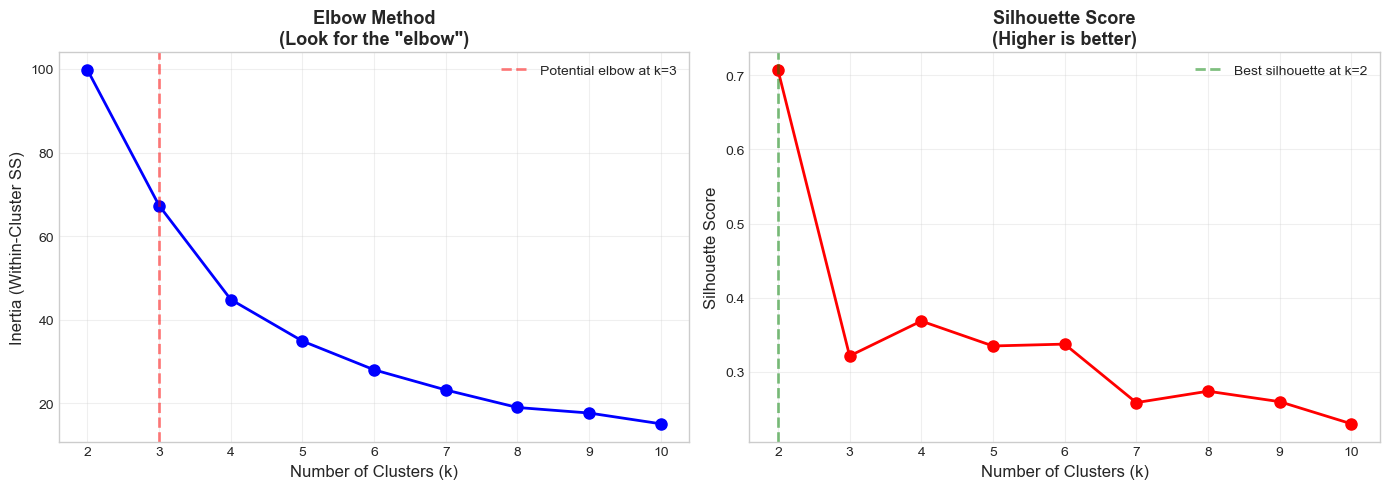


ANALYZING CLUSTER QUALITY

📈 Elbow Method → suggests k=3
🤝 Silhouette Method → suggests k=2 (score=0.707)

✅ Final Decision:
   Optimal number of clusters (k) = 2
   Reason: Both methods consistent (±1)
   Silhouette Score = 0.707

✅ ELBOW ANALYSIS COMPLETE — OPTIMAL k = 2


In [11]:
# ==============================================================
#  STEP 1.3.1 — FINDING OPTIMAL NUMBER OF CLUSTERS (K-MEANS)
# ==============================================================

print("=" * 70)
print("FINDING OPTIMAL NUMBER OF CLUSTERS — PCA-BASED K-MEANS")
print("=" * 70)

print("\n🎯 Goal: Determine the optimal k (number of clusters)")
print("   We'll use the PCA-transformed data (3 components).")
print("   Methods used:")
print("   1. Elbow Method  → detects 'knee' in inertia drop")
print("   2. Silhouette Score  → measures cluster quality\n")

# ✅ Use PCA-transformed data (NOT raw features)
X_cluster = X_pca[:, :3]
print(f"📊 Using PCA data with shape: {X_cluster.shape}")

# Initialize temporary K-Means model
kmeans_temp = SimpleKMeans(n_clusters=3, random_state=42)

# Run elbow + silhouette analysis
fig = kmeans_temp.plot_elbow(X_cluster, max_k=10, figsize=(14, 5))
plt.show()

# ==============================================================
#  ANALYSIS OF RESULTS
# ==============================================================

print("\n" + "=" * 70)
print("ANALYZING CLUSTER QUALITY")
print("=" * 70)

# Recompute metrics numerically to extract best k
X_scaled = kmeans_temp.scaler.fit_transform(X_cluster)
inertias, silhouettes = [], []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

# Compute elbow (based on inertia 2nd derivative)
inertia_diffs = np.diff(inertias)
inertia_diffs2 = np.diff(inertia_diffs)
elbow_k = np.argmax(inertia_diffs2) + 2

# Find best silhouette score
best_silhouette_idx = np.argmax(silhouettes)
best_silhouette_k = list(K_range)[best_silhouette_idx]
best_silhouette_score = silhouettes[best_silhouette_idx]

print(f"\n📈 Elbow Method → suggests k={elbow_k}")
print(f"🤝 Silhouette Method → suggests k={best_silhouette_k} (score={best_silhouette_score:.3f})")

# Decide final k
if abs(elbow_k - best_silhouette_k) <= 1:
    optimal_k = best_silhouette_k
    reason = "Both methods consistent (±1)"
else:
    optimal_k = best_silhouette_k
    reason = "Silhouette preferred for cluster quality"

print("\n✅ Final Decision:")
print(f"   Optimal number of clusters (k) = {optimal_k}")
print(f"   Reason: {reason}")
print(f"   Silhouette Score = {silhouettes[optimal_k-2]:.3f}")

# Save optimal k for next step
print("\n" + "=" * 70)
print(f"✅ ELBOW ANALYSIS COMPLETE — OPTIMAL k = {optimal_k}")
print("=" * 70)

FITTING K-MEANS WITH OPTIMAL k=2

🔧 Initializing K-Means with k=2 clusters...
   This will:
   1. Standardize PCA components
   2. Run K-Means algorithm (may take a few seconds)
   3. Assign each token to a cluster
   4. Calculate cluster centroids


✅ K-Means fitted successfully!
   Number of clusters: 2
   Inertia (within-cluster sum of squares): 99.80
   Lower inertia = tighter clusters

CLUSTER ASSIGNMENT COMPLETE

✅ All 47 tokens assigned to 2 clusters

📊 CLUSTER DISTRIBUTION:


,Cluster,Size,Percentage
0,0,46,97.9%
1,1,1,2.1%


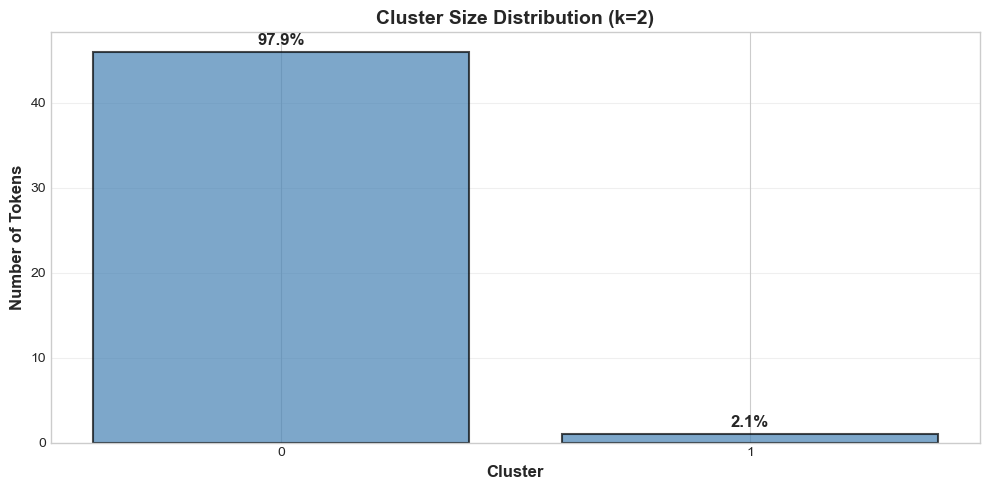


🔍 Balance Analysis:
   ⚠️  IMBALANCED: Largest cluster is 46.0x bigger than smallest

CLUSTER CHARACTERISTICS (CENTROIDS)

📋 Centroid Table (Average component values):


,PC1,PC2,PC3
Cluster_0,-0.143,0.151,0.072
Cluster_1,6.572,-6.949,-3.292



🎯 Most distinguishing components between clusters:

   1. PC2        (variation: 1.48)
   2. PC1        (variation: 1.48)
   3. PC3        (variation: 1.48)

💡 Interpretation:
   • If PC1 differs most → clusters differ mainly by SIZE/LIQUIDITY
   • If PC2 differs most → clusters differ by RISK/RETURN
   • If PC3 differs most → clusters differ by MARKET EXPOSURE

DETAILED CLUSTER ANALYSIS (in PCA space)

Cluster 0: 46 tokens (97.9%)
   Mean PC1=-0.143, PC2=0.151, PC3=0.072
   → Smaller / More volatile tokens
   Sample tokens: BTC-USD, ETH-USD, BNB-USD, SOL-USD, XRP-USD, ADA-USD

Cluster 1: 1 tokens (2.1%)
   Mean PC1=6.572, PC2=-6.949, PC3=-3.292
   → Likely Large-cap / Stable tokens
   Sample tokens: TRX-USD

✅ CLUSTER ANALYSIS COMPLETE

🎯 Tokens successfully segmented into 2 clusters using PCA space.
   Each cluster represents a distinct DeFi token profile (size, volatility, exposure).


In [12]:
print("=" * 70)
print(f"FITTING K-MEANS WITH OPTIMAL k={optimal_k}")
print("=" * 70)

print(f"\n🔧 Initializing K-Means with k={optimal_k} clusters...")
print("   This will:")
print("   1. Standardize PCA components")
print("   2. Run K-Means algorithm (may take a few seconds)")
print("   3. Assign each token to a cluster")
print("   4. Calculate cluster centroids\n")

# Initialize K-Means with optimal k
kmeans_model = SimpleKMeans(n_clusters=optimal_k, random_state=42)

# ✅ Fit K-Means on PCA data (3 components)
clusters = kmeans_model.fit_predict(
    X_pca[:, :3],
    feature_names=[f"PC{i+1}" for i in range(3)]
)

print("\n" + "=" * 70)
print("CLUSTER ASSIGNMENT COMPLETE")
print("=" * 70)

# Add cluster labels to tokens
defi_data_clustered = defi_data.copy()
defi_data_clustered['Cluster'] = clusters

print(f"\n✅ All {len(defi_data)} tokens assigned to {optimal_k} clusters")

# ✅ Get cluster summary
cluster_summary = kmeans_model.get_cluster_summary(X_pca[:, :3])

print("\n📊 CLUSTER DISTRIBUTION:")
print("=" * 70)
display(cluster_summary)

# Bar plot
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(cluster_summary['Cluster'], cluster_summary['Size'], 
              alpha=0.7, color='steelblue', edgecolor='black', linewidth=1.5)

for i, (idx, row) in enumerate(cluster_summary.iterrows()):
    ax.text(row['Cluster'], row['Size'] + 0.5, row['Percentage'], 
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Tokens', fontsize=12, fontweight='bold')
ax.set_title(f'Cluster Size Distribution (k={optimal_k})', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.set_xticks(cluster_summary['Cluster'])

plt.tight_layout()
plt.show()

# Balance analysis
print("\n🔍 Balance Analysis:")
max_size = cluster_summary['Size'].max()
min_size = cluster_summary['Size'].min()
size_ratio = max_size / min_size

if size_ratio > 5:
    print(f"   ⚠️  IMBALANCED: Largest cluster is {size_ratio:.1f}x bigger than smallest")
elif size_ratio > 2.5:
    print(f"   ⚠️  SOMEWHAT IMBALANCED: Size ratio is {size_ratio:.1f}x")
else:
    print(f"   ✅ WELL BALANCED: Size ratio is {size_ratio:.1f}x")

print("\n" + "=" * 70)
print("CLUSTER CHARACTERISTICS (CENTROIDS)")
print("=" * 70)

# ✅ Centroids in PCA space
centroids = kmeans_model.get_cluster_centers()

print("\n📋 Centroid Table (Average component values):")
display(centroids.round(3))

# Variability per PC
feature_cv = centroids.std() / (centroids.mean().abs() + 1e-10)
distinguishing_features = feature_cv.sort_values(ascending=False)

print("\n🎯 Most distinguishing components between clusters:\n")
for i, (feature, cv) in enumerate(distinguishing_features.head(3).items(), 1):
    print(f"   {i}. {feature:10s} (variation: {cv:.2f})")

print("\n💡 Interpretation:")
print("   • If PC1 differs most → clusters differ mainly by SIZE/LIQUIDITY")
print("   • If PC2 differs most → clusters differ by RISK/RETURN")
print("   • If PC3 differs most → clusters differ by MARKET EXPOSURE")

print("\n" + "=" * 70)
print("DETAILED CLUSTER ANALYSIS (in PCA space)")
print("=" * 70)

for i in range(optimal_k):
    cluster_data = defi_data_clustered[defi_data_clustered['Cluster'] == i]
    print(f"\nCluster {i}: {len(cluster_data)} tokens ({len(cluster_data)/len(defi_data)*100:.1f}%)")
    
    # PCA averages
    centroid_vals = centroids.iloc[i]
    print(f"   Mean PC1={centroid_vals['PC1']:.3f}, PC2={centroid_vals['PC2']:.3f}, PC3={centroid_vals['PC3']:.3f}")
    
    if centroid_vals['PC1'] > 0 and centroid_vals['PC2'] < 0:
        print("   → Likely Large-cap / Stable tokens")
    elif centroid_vals['PC1'] < 0 and centroid_vals['PC2'] > 0:
        print("   → Smaller / More volatile tokens")
    else:
        print("   → Mixed or transitional group")

    print(f"   Sample tokens: {', '.join(cluster_data.index[:6])}")

print("\n" + "=" * 70)
print("✅ CLUSTER ANALYSIS COMPLETE")
print("=" * 70)
print(f"\n🎯 Tokens successfully segmented into {optimal_k} clusters using PCA space.")
print("   Each cluster represents a distinct DeFi token profile (size, volatility, exposure).")

VISUALIZING CLUSTERS IN 2D PCA SPACE

🎯 Goal: Visualize how our DeFi tokens group in 2D
   We'll project the 8-dimensional features onto two main PCA axes (PC1 & PC2).
   Then, color-code tokens according to their cluster assignment.

Step 1: Applying PCA reduction to 2D...

✅ PCA fitted successfully!
   Components: 2
   Total variance explained: 76.29%
✅ PCA complete!
   • PC1 explains: 46.9% of variance
   • PC2 explains: 29.4% of variance
   • Total captured in 2D: 76.3%
🌟 Excellent 2D coverage: 76.3% variance retained

Top contributing features to PC1 (X-axis):
   • Max_Drawdown: +0.468
   • Sharpe_Ratio: +0.446
   • Downside_Vol: -0.443

Top contributing features to PC2 (Y-axis):
   • Corr_BTC: +0.562
   • Skewness: -0.484
   • Kurtosis: -0.476

Step 2: Plotting the clusters in 2D space...


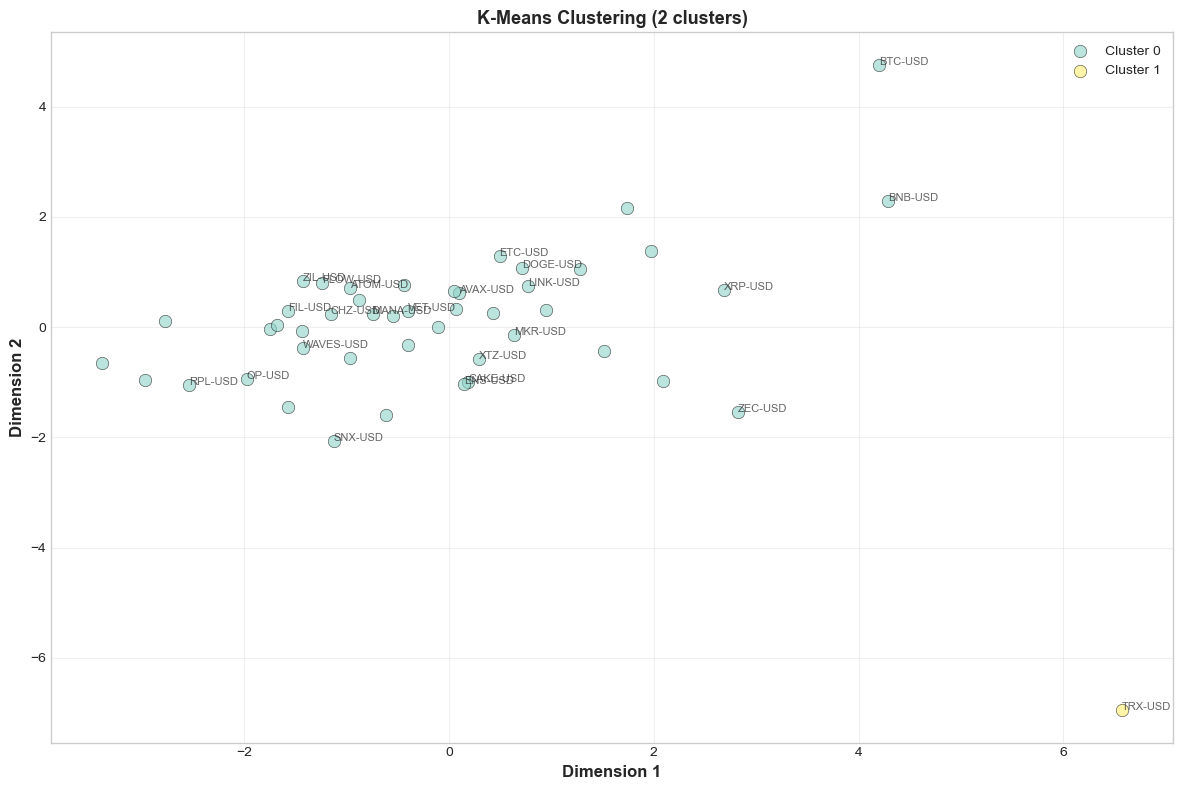


ANALYZING CLUSTER GEOMETRY

Cluster 0:
   Center:  PC1=-0.14,  PC2=+0.15
   Spread:  ±1.70  (PC1),  ±1.15  (PC2)

Cluster 1:
   Center:  PC1=+6.57,  PC2=-6.95
   Spread:  ±0.00  (PC1),  ±0.00  (PC2)

📏 Distances between cluster centers:
   Cluster 0 ↔ Cluster 1: 9.77
✅ Excellent separation

IDENTIFYING OUTLIERS IN 2D PCA SPACE
⚠️  Found 2 potential outliers:


,Token,Cluster,Distance
0,BTC-USD,0,6.336747
1,BNB-USD,0,4.924438



QUADRANT ANALYSIS (PC1–PC2)
   High PC1, High PC2  : 14 tokens ( 29.8%)
   Low PC1, High PC2   : 13 tokens ( 27.7%)
   Low PC1, Low PC2    : 12 tokens ( 25.5%)
   High PC1, Low PC2   :  8 tokens ( 17.0%)

💡 Interpretation:
   • High PC1 → large, liquid tokens
   • Low PC1  → small, niche tokens
   • High PC2 → riskier / more volatile
   • Low PC2  → stable / low risk

VISUALIZATION QUALITY CHECK
⚠️  Visualization acceptable but may require tuning (k or features).

✅ 2D cluster visualization complete.


In [13]:
# ==========================================================
# STEP 1.3.3 — VISUALIZING K-MEANS CLUSTERS IN PCA SPACE
# ==========================================================

print("=" * 70)
print("VISUALIZING CLUSTERS IN 2D PCA SPACE")
print("=" * 70)

print("\n🎯 Goal: Visualize how our DeFi tokens group in 2D")
print("   We'll project the 8-dimensional features onto two main PCA axes (PC1 & PC2).")
print("   Then, color-code tokens according to their cluster assignment.\n")

# ==========================================================
# STEP 1 — APPLY PCA TO REDUCE FEATURES TO 2D
# ==========================================================
print("Step 1: Applying PCA reduction to 2D...")

pca_2d = SimplePCA(n_components=2)
X_2d = pca_2d.fit_transform(defi_data.values, feature_names=defi_data.columns.tolist())

var_pc1 = pca_2d.pca.explained_variance_ratio_[0]
var_pc2 = pca_2d.pca.explained_variance_ratio_[1]
total_var_2d = var_pc1 + var_pc2

print(f"✅ PCA complete!")
print(f"   • PC1 explains: {var_pc1:.1%} of variance")
print(f"   • PC2 explains: {var_pc2:.1%} of variance")
print(f"   • Total captured in 2D: {total_var_2d:.1%}")

if total_var_2d < 0.50:
    print(f"⚠️  Warning: Only {total_var_2d:.1%} variance retained (may hide separation)")
elif total_var_2d < 0.70:
    print(f"✅ Good representation: {total_var_2d:.1%} of variance captured")
else:
    print(f"🌟 Excellent 2D coverage: {total_var_2d:.1%} variance retained")

# ==========================================================
# STEP 2 — INTERPRET THE PCA AXES
# ==========================================================
loadings_2d = pca_2d.get_loadings()

print("\nTop contributing features to PC1 (X-axis):")
pc1_top = loadings_2d['PC1'].abs().nlargest(3)
for feat in pc1_top.index:
    val = loadings_2d.loc[feat, 'PC1']
    print(f"   • {feat}: {val:+.3f}")

print("\nTop contributing features to PC2 (Y-axis):")
pc2_top = loadings_2d['PC2'].abs().nlargest(3)
for feat in pc2_top.index:
    val = loadings_2d.loc[feat, 'PC2']
    print(f"   • {feat}: {val:+.3f}")

# ==========================================================
# STEP 3 — PLOT THE CLUSTERS IN 2D
# ==========================================================
print("\n" + "=" * 70)
print("Step 2: Plotting the clusters in 2D space...")
print("=" * 70)

fig = kmeans_model.plot_clusters_2d(
    X_2d,
    labels=defi_data.index.tolist(),
    figsize=(12, 8)
)
plt.show()

# ==========================================================
# STEP 4 — ANALYZE CLUSTER POSITIONS
# ==========================================================
print("\n" + "=" * 70)
print("ANALYZING CLUSTER GEOMETRY")
print("=" * 70)

clusters = kmeans_model.kmeans.labels_
for i in range(optimal_k):
    mask = clusters == i
    cluster_pts = X_2d[mask]
    center_x, center_y = cluster_pts.mean(axis=0)
    spread_x, spread_y = cluster_pts.std(axis=0)
    print(f"\nCluster {i}:")
    print(f"   Center:  PC1={center_x:+.2f},  PC2={center_y:+.2f}")
    print(f"   Spread:  ±{spread_x:.2f}  (PC1),  ±{spread_y:.2f}  (PC2)")

# ==========================================================
# STEP 5 — CLUSTER SEPARATION
# ==========================================================
from scipy.spatial.distance import pdist, squareform

centers_2d = np.array([
    X_2d[clusters == i].mean(axis=0)
    for i in range(optimal_k)
])
distances = squareform(pdist(centers_2d, metric='euclidean'))

print("\n📏 Distances between cluster centers:")
for i in range(optimal_k):
    for j in range(i + 1, optimal_k):
        print(f"   Cluster {i} ↔ Cluster {j}: {distances[i, j]:.2f}")

avg_sep = distances[np.triu_indices_from(distances, 1)].mean()
if avg_sep > 3:
    print("✅ Excellent separation")
elif avg_sep > 2:
    print("✅ Good separation")
elif avg_sep > 1:
    print("⚠️  Moderate separation (some overlap)")
else:
    print("❌ Weak separation")

# ==========================================================
# STEP 6 — OUTLIER DETECTION
# ==========================================================
print("\n" + "=" * 70)
print("IDENTIFYING OUTLIERS IN 2D PCA SPACE")
print("=" * 70)

outliers = []
for i in range(optimal_k):
    mask = clusters == i
    pts = X_2d[mask]
    tokens = defi_data.index[mask]
    center = pts.mean(axis=0)
    dist = np.sqrt(((pts - center)**2).sum(axis=1))
    threshold = dist.mean() + 2.5 * dist.std()
    for token, d in zip(tokens, dist):
        if d > threshold:
            outliers.append((token, i, d))

if outliers:
    df_out = pd.DataFrame(outliers, columns=["Token", "Cluster", "Distance"])
    print(f"⚠️  Found {len(df_out)} potential outliers:")
    display(df_out.sort_values("Distance", ascending=False))
else:
    print("✅ No major outliers detected")

# ==========================================================
# STEP 7 — QUADRANT ANALYSIS
# ==========================================================
print("\n" + "=" * 70)
print("QUADRANT ANALYSIS (PC1–PC2)")
print("=" * 70)

quadrants = {
    "High PC1, High PC2": (X_2d[:, 0] > 0) & (X_2d[:, 1] > 0),
    "Low PC1, High PC2":  (X_2d[:, 0] < 0) & (X_2d[:, 1] > 0),
    "Low PC1, Low PC2":   (X_2d[:, 0] < 0) & (X_2d[:, 1] < 0),
    "High PC1, Low PC2":  (X_2d[:, 0] > 0) & (X_2d[:, 1] < 0),
}

for name, mask in quadrants.items():
    count = mask.sum()
    pct = 100 * count / len(defi_data)
    print(f"   {name:20s}: {count:2d} tokens ({pct:5.1f}%)")

print("\n💡 Interpretation:")
print("   • High PC1 → large, liquid tokens")
print("   • Low PC1  → small, niche tokens")
print("   • High PC2 → riskier / more volatile")
print("   • Low PC2  → stable / low risk")

# ==========================================================
# STEP 8 — FINAL ASSESSMENT
# ==========================================================
print("\n" + "=" * 70)
print("VISUALIZATION QUALITY CHECK")
print("=" * 70)

balance_ok = cluster_summary['Size'].std() < len(defi_data) * 0.2
coverage_ok = total_var_2d > 0.5
outlier_ok = len(outliers) < len(defi_data) * 0.1
sep_ok = avg_sep > 1.5

if all([balance_ok, coverage_ok, outlier_ok, sep_ok]):
    print("✅ Overall visualization looks strong and meaningful.")
else:
    print("⚠️  Visualization acceptable but may require tuning (k or features).")

print("\n✅ 2D cluster visualization complete.")

In [17]:
# ==========================================================
# STEP 1.4 — CLUSTER DOCUMENTATION & TOKEN COMPOSITION (FIXED)
# ==========================================================

print("=" * 70)
print("STEP 1.4 — CLUSTER DOCUMENTATION & TOKEN COMPOSITION")
print("=" * 70)

# Βεβαιώσου ότι υπάρχει στήλη "Cluster"
assert "Cluster" in defi_data_clustered.columns, "Missing 'Cluster' column!"

print("\n🧩 Features detected:")
print(defi_data_clustered.columns.tolist())

cluster_docs = []
for i in range(optimal_k):
    cluster_data = defi_data_clustered[defi_data_clustered["Cluster"] == i]
    size = len(cluster_data)
    pct = size / len(defi_data_clustered) * 100

    avg_feats = cluster_data.drop(columns="Cluster").mean()
    avg_vol = avg_feats.get("Volatility", np.nan)
    avg_ret = avg_feats.get("Mean_Return", np.nan)
    avg_liq = avg_feats.get("Liquidity_Score", np.nan)
    avg_corr = avg_feats.get("Corr_BTC", np.nan) or avg_feats.get("ETH_Correlation", np.nan)
    avg_dd = avg_feats.get("Max_Drawdown", np.nan)
    avg_sharpe = avg_feats.get("Sharpe_Ratio", np.nan)

    # === ΧΑΡΑΚΤΗΡΙΣΜΟΣ CLUSTER ===
    profile = ""

    if avg_sharpe > defi_data_clustered["Sharpe_Ratio"].mean() * 1.2 and avg_vol < defi_data_clustered["Volatility"].mean() * 0.8:
        profile = "🏛️ Low-risk / High-efficiency cluster"
    elif avg_vol > defi_data_clustered["Volatility"].mean() * 1.3:
        profile = "🚀 High-volatility / High-risk cluster"
    elif avg_ret > defi_data_clustered["Mean_Return"].mean() * 1.3:
        profile = "📈 High-return / Opportunistic cluster"
    else:
        profile = "⚖️ Balanced / Mid-risk cluster"

    if avg_corr is not np.nan:
        if avg_corr > 0.7:
            profile += " • High BTC correlation"
        elif avg_corr < 0.3:
            profile += " • Low BTC correlation"

    if avg_liq is not np.nan and avg_liq > defi_data_clustered["Downside_Vol"].mean() * 1.2:
        profile += " • Highly liquid"

    # === ΕΝΔΕΙΚΤΙΚΑ TOKENS ===
    sample_tokens = cluster_data.index[:8].tolist()
    sample_str = ", ".join(sample_tokens)
    if size > 8:
        sample_str += f" (+{size-8} more)"

    cluster_docs.append({
        "Cluster": i,
        "Size": size,
        "Percentage": f"{pct:.1f}%",
        "Avg Volatility": f"{avg_vol:.3f}",
        "Avg Return": f"{avg_ret:.4f}",
        "Avg Sharpe": f"{avg_sharpe:.3f}",
        "Avg Drawdown": f"{avg_dd:.3f}",
        "Profile": profile,
        "Sample Tokens": sample_str
    })

# === Πίνακας Περίληψης ===
cluster_doc_df = pd.DataFrame(cluster_docs)
display(cluster_doc_df)

print("\n" + "=" * 70)
print("DETAILED CLUSTER SUMMARY")
print("=" * 70)

for _, row in cluster_doc_df.iterrows():
    print(f"\nCLUSTER {row['Cluster']} — {row['Profile']}")
    print(f"   • Size: {row['Size']} tokens ({row['Percentage']})")
    print(f"   • Avg Volatility: {row['Avg Volatility']}")
    print(f"   • Avg Return: {row['Avg Return']}")
    print(f"   • Avg Sharpe: {row['Avg Sharpe']}")
    print(f"   • Avg Drawdown: {row['Avg Drawdown']}")
    print(f"   • Tokens: {row['Sample Tokens']}")
    print("-" * 70)

print("\n✅ Cluster documentation complete.")
print("💡 These profiles can now be used for economic interpretation (Part 2).")

STEP 1.4 — CLUSTER DOCUMENTATION & TOKEN COMPOSITION

🧩 Features detected:
['Mean_Return', 'Volatility', 'Sharpe_Ratio', 'Downside_Vol', 'Max_Drawdown', 'Corr_BTC', 'Skewness', 'Kurtosis', 'Cluster']


,Cluster,Size,Percentage,Avg Volatility,Avg Return,Avg Sharpe,Avg Drawdown,Profile,Sample Tokens
0,0,46,97.9%,0.049,0.0011,0.023,-0.739,⚖️ Balanced / Mid-risk cluster,"BTC-USD, ETH-USD, BNB-USD, SOL-USD, XRP-USD, A..."
1,1,1,2.1%,0.042,0.0022,0.052,-0.502,📈 High-return / Opportunistic cluster • Low BT...,TRX-USD



DETAILED CLUSTER SUMMARY

CLUSTER 0 — ⚖️ Balanced / Mid-risk cluster
   • Size: 46 tokens (97.9%)
   • Avg Volatility: 0.049
   • Avg Return: 0.0011
   • Avg Sharpe: 0.023
   • Avg Drawdown: -0.739
   • Tokens: BTC-USD, ETH-USD, BNB-USD, SOL-USD, XRP-USD, ADA-USD, AVAX-USD, DOT-USD (+38 more)
----------------------------------------------------------------------

CLUSTER 1 — 📈 High-return / Opportunistic cluster • Low BTC correlation
   • Size: 1 tokens (2.1%)
   • Avg Volatility: 0.042
   • Avg Return: 0.0022
   • Avg Sharpe: 0.052
   • Avg Drawdown: -0.502
   • Tokens: TRX-USD
----------------------------------------------------------------------

✅ Cluster documentation complete.
💡 These profiles can now be used for economic interpretation (Part 2).


BUILDING A CLUSTER-BASED DIVERSIFIED PORTFOLIO

🎯 Portfolio Construction Strategy:
   • Method: Quality-weighted selection using Sharpe ratio
   • Tokens per cluster: 2 (for balanced representation)
   • Weighting: Equal weight across selected tokens
   • Total portfolio size: Varies by number of clusters

💡 Why Sharpe Ratio?
   Sharpe = Mean_Return / Volatility
   → Measures return per unit of risk
   → Higher is better (more return for the risk)

Step 1: Calculating Sharpe ratio for all tokens...
   ✅ Sharpe ratios calculated

📊 Sharpe Ratio Distribution:
   Mean:      0.024
   Median:    0.020
   Min:      -0.032
   Max:       0.091

Step 2: Selecting top tokens from each cluster...

Cluster 0 (46 tokens):
   1. ZEC-USD         - Sharpe:  0.091 (Return:  0.0053, Vol: 0.0584)
   2. BNB-USD         - Sharpe:  0.087 (Return:  0.0026, Vol: 0.0294)

Cluster 1 (1 tokens):
   1. TRX-USD         - Sharpe:  0.052 (Return:  0.0022, Vol: 0.0421)

PORTFOLIO CONSTRUCTED!

✅ Selected 3 tokens for

,Token,Cluster,Mean_Return,Volatility,Sharpe_Ratio,Downside_Vol,Max_Drawdown,Corr_BTC,Skewness,Kurtosis
0,ZEC-USD,0,0.005300,0.058424,0.090707,0.030272,-0.608607,0.385564,2.338955,19.082494
1,BNB-USD,0,0.002565,0.029384,0.087299,0.018979,-0.346023,0.605123,0.563118,4.115277
2,TRX-USD,1,0.002205,0.042082,0.052390,0.020121,-0.501824,0.214364,14.626638,328.658195



💰 Portfolio Weights:


,Token,Cluster,Weight_Pct
0,ZEC-USD,0,33.33%
1,BNB-USD,0,33.33%
2,TRX-USD,1,33.33%



PORTFOLIO STATISTICS

📊 Portfolio Performance Metrics:
   Expected Daily Return:       0.0034 (0.34%)
   Expected Daily Volatility:   0.0259 (2.59%)
   Portfolio Sharpe Ratio:       0.129

📊 Annualized Estimates (×252 trading days):
   Annual Return:        84.58%
   Annual Volatility:    41.15%
   Annual Sharpe:         0.129

CLUSTER REPRESENTATION IN PORTFOLIO

📊 Portfolio Composition by Cluster:


,Num_Tokens,Weight,Mean_Return,Volatility,Sharpe_Ratio,Weight_Pct
Cluster,,,,,,
0,2,0.6667,0.0039,0.0439,0.0890,66.6667
1,1,0.3333,0.0022,0.0421,0.0524,33.3333



   Cluster 0: 2 tokens (66.7% of portfolio)
   • Average return: 0.0039
   • Average volatility: 0.0439

   Cluster 1: 1 tokens (33.3% of portfolio)
   • Average return: 0.0022
   • Average volatility: 0.0421

   ⚠️  Somewhat imbalanced (std dev: 23.6%)

VISUALIZATIONS


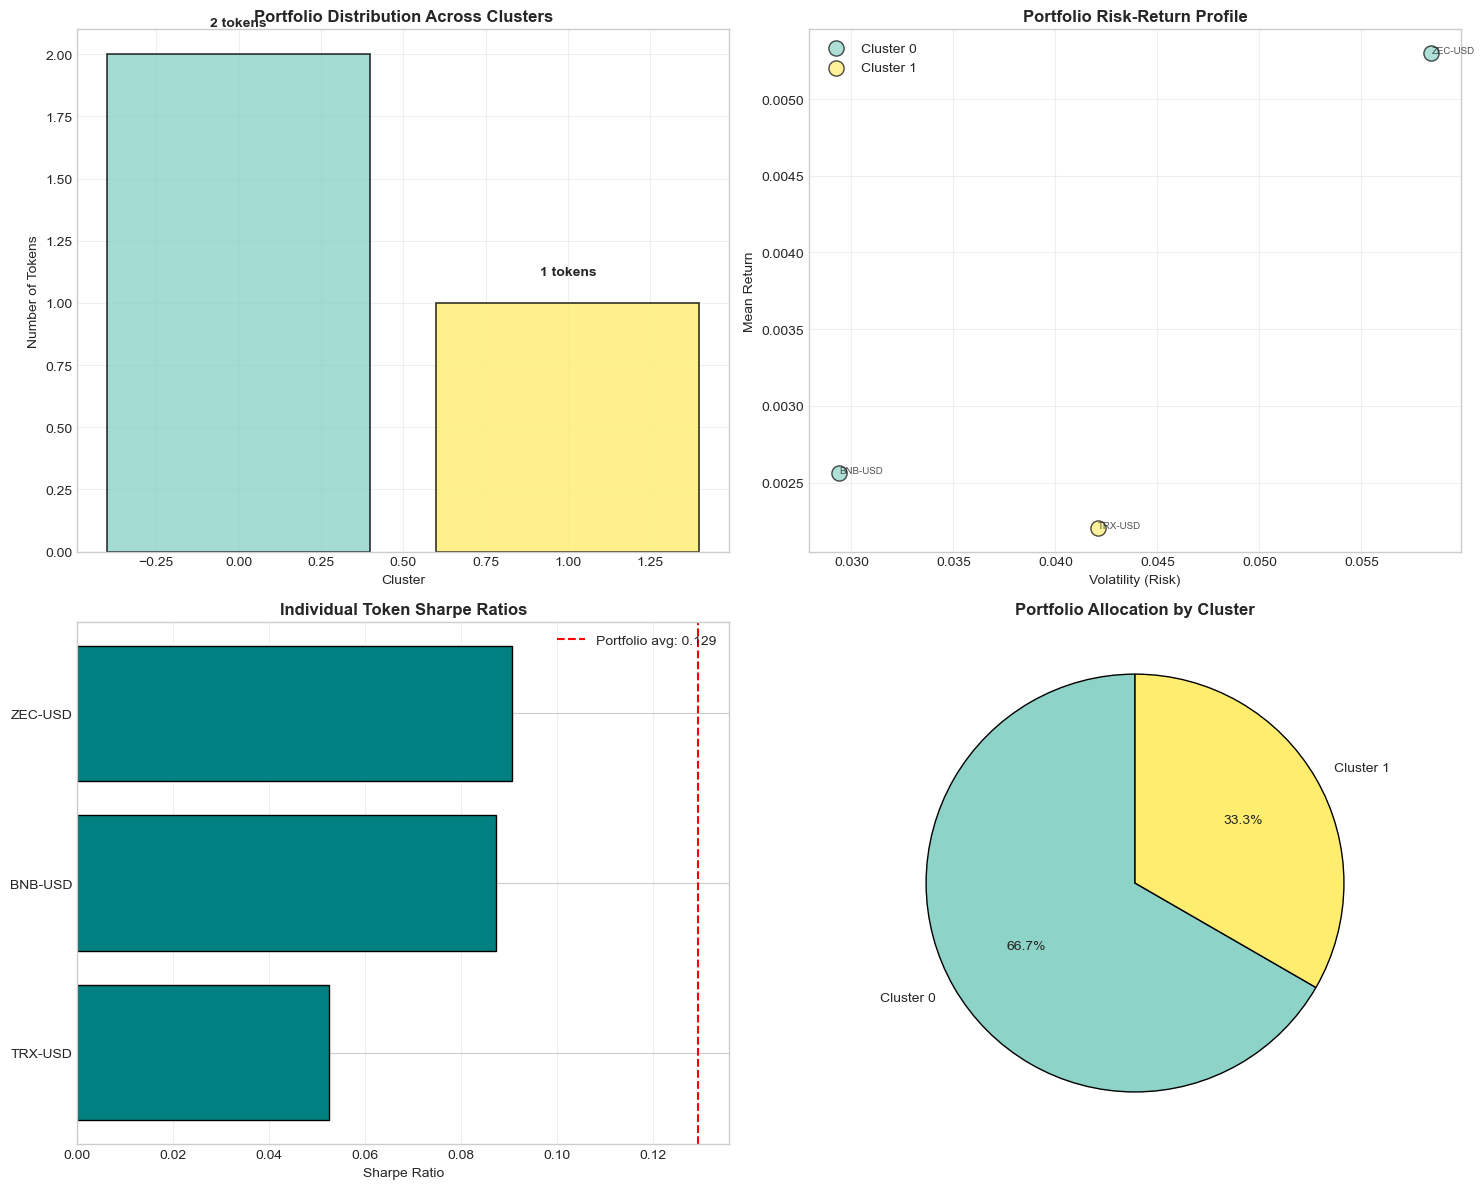


PORTFOLIO RECOMMENDATIONS

   Risk Profile: 🛡️ CONSERVATIVE
   Portfolio volatility: 0.0259
   Market average: 0.0493

💡 Management Recommendations:
   • Rebalance monthly or when weights drift >5%
   • Monitor cluster transitions quarterly
   • Review Sharpe ratio evolution per token
   • Maintain diversification across clusters

✅ Portfolio construction complete!

📋 PORTFOLIO SUMMARY:
   • Total tokens: 3
   • Clusters represented: 2/2
   • Expected annual return: 84.58%
   • Expected annual volatility: 41.15%
   • Annual Sharpe ratio: 0.129


In [18]:
print("=" * 70)
print("BUILDING A CLUSTER-BASED DIVERSIFIED PORTFOLIO")
print("=" * 70)

print("\n🎯 Portfolio Construction Strategy:")
print("   • Method: Quality-weighted selection using Sharpe ratio")
print("   • Tokens per cluster: 2 (for balanced representation)")
print("   • Weighting: Equal weight across selected tokens")
print("   • Total portfolio size: Varies by number of clusters\n")

print("💡 Why Sharpe Ratio?")
print("   Sharpe = Mean_Return / Volatility")
print("   → Measures return per unit of risk")
print("   → Higher is better (more return for the risk)\n")

# ==========================================================
# Step 1: Calculate (or confirm) Sharpe ratio
# ==========================================================
print("Step 1: Calculating Sharpe ratio for all tokens...")

if 'Sharpe_Ratio' not in defi_data_clustered.columns:
    defi_data_clustered['Sharpe_Ratio'] = (
        defi_data_clustered['Mean_Return'] / 
        (defi_data_clustered['Volatility'] + 1e-10)
    )

print("   ✅ Sharpe ratios calculated\n")

print("📊 Sharpe Ratio Distribution:")
sharpe_stats = defi_data_clustered['Sharpe_Ratio'].describe()
print(f"   Mean:   {sharpe_stats['mean']:>8.3f}")
print(f"   Median: {sharpe_stats['50%']:>8.3f}")
print(f"   Min:    {sharpe_stats['min']:>8.3f}")
print(f"   Max:    {sharpe_stats['max']:>8.3f}")

# ==========================================================
# Step 2: Select top tokens per cluster based on Sharpe
# ==========================================================
print("\n" + "=" * 70)
print("Step 2: Selecting top tokens from each cluster...")
print("=" * 70)

tokens_per_cluster = 2
portfolio = []

for i in range(optimal_k):
    cluster_data = defi_data_clustered[defi_data_clustered['Cluster'] == i].copy()
    print(f"\nCluster {i} ({len(cluster_data)} tokens):")
    
    # Sort by Sharpe ratio and select top N
    cluster_data_sorted = cluster_data.sort_values('Sharpe_Ratio', ascending=False)
    selected = cluster_data_sorted.head(tokens_per_cluster)
    
    # Add to portfolio list
    for idx, token in enumerate(selected.index):
        token_data = selected.loc[token]
        portfolio.append({
            'Token': token,
            'Cluster': i,
            'Mean_Return': float(token_data['Mean_Return']),
            'Volatility': float(token_data['Volatility']),
            'Sharpe_Ratio': float(token_data['Sharpe_Ratio']),
            'Downside_Vol': float(token_data['Downside_Vol']),
            'Max_Drawdown': float(token_data['Max_Drawdown']),
            'Corr_BTC': float(token_data['Corr_BTC']),
            'Skewness': float(token_data['Skewness']),
            'Kurtosis': float(token_data['Kurtosis'])
        })
        
        print(f"   {idx+1}. {token:15s} - Sharpe: {token_data['Sharpe_Ratio']:>6.3f} "
              f"(Return: {token_data['Mean_Return']:>7.4f}, Vol: {token_data['Volatility']:>6.4f})")

# Convert to DataFrame
portfolio_df = pd.DataFrame(portfolio)

# ==========================================================
# Step 3: Portfolio summary and weights
# ==========================================================
print("\n" + "=" * 70)
print("PORTFOLIO CONSTRUCTED!")
print("=" * 70)
print(f"\n✅ Selected {len(portfolio_df)} tokens for the portfolio "
      f"({tokens_per_cluster} tokens × {optimal_k} clusters)")

print("\n📋 Complete Portfolio:")
display(portfolio_df)

# Equal weights
portfolio_df['Weight'] = 1.0 / len(portfolio_df)
portfolio_df['Weight_Pct'] = portfolio_df['Weight'] * 100

print("\n💰 Portfolio Weights:")
weight_display = portfolio_df[['Token', 'Cluster', 'Weight_Pct']].copy()
weight_display['Weight_Pct'] = weight_display['Weight_Pct'].apply(lambda x: f"{x:.2f}%")
display(weight_display)

# ==========================================================
# Step 4: Portfolio-level statistics
# ==========================================================
print("\n" + "=" * 70)
print("PORTFOLIO STATISTICS")
print("=" * 70)

# Simple portfolio-level metrics (using the 8 feature stats)
portfolio_return = (portfolio_df['Mean_Return'] * portfolio_df['Weight']).sum()
portfolio_volatility = np.sqrt((portfolio_df['Volatility']**2 * portfolio_df['Weight']**2).sum())
portfolio_sharpe = portfolio_return / portfolio_volatility if portfolio_volatility > 0 else 0

print("\n📊 Portfolio Performance Metrics:")
print(f"   Expected Daily Return:     {portfolio_return:>8.4f} ({portfolio_return*100:.2f}%)")
print(f"   Expected Daily Volatility: {portfolio_volatility:>8.4f} ({portfolio_volatility*100:.2f}%)")
print(f"   Portfolio Sharpe Ratio:    {portfolio_sharpe:>8.3f}")

# Annualized
annual_return = portfolio_return * 252
annual_vol = portfolio_volatility * np.sqrt(252)
print(f"\n📊 Annualized Estimates (×252 trading days):")
print(f"   Annual Return:      {annual_return:>8.2%}")
print(f"   Annual Volatility:  {annual_vol:>8.2%}")
print(f"   Annual Sharpe:      {portfolio_sharpe:>8.3f}")

# ==========================================================
# Step 5: Cluster representation
# ==========================================================
print("\n" + "=" * 70)
print("CLUSTER REPRESENTATION IN PORTFOLIO")
print("=" * 70)

cluster_representation = portfolio_df.groupby('Cluster').agg({
    'Token': 'count',
    'Weight': 'sum',
    'Mean_Return': 'mean',
    'Volatility': 'mean',
    'Sharpe_Ratio': 'mean'
}).rename(columns={'Token': 'Num_Tokens'})

cluster_representation['Weight_Pct'] = cluster_representation['Weight'] * 100

print("\n📊 Portfolio Composition by Cluster:")
display(cluster_representation.round(4))

for i in range(optimal_k):
    if i in cluster_representation.index:
        num_tokens = cluster_representation.loc[i, 'Num_Tokens']
        weight_pct = cluster_representation.loc[i, 'Weight_Pct']
        avg_return = cluster_representation.loc[i, 'Mean_Return']
        avg_vol = cluster_representation.loc[i, 'Volatility']
        print(f"\n   Cluster {i}: {num_tokens} tokens ({weight_pct:.1f}% of portfolio)")
        print(f"   • Average return: {avg_return:.4f}")
        print(f"   • Average volatility: {avg_vol:.4f}")

weight_std = cluster_representation['Weight_Pct'].std()
if weight_std < 5:
    print("\n   ✅ Well-balanced across clusters")
else:
    print(f"\n   ⚠️  Somewhat imbalanced (std dev: {weight_std:.1f}%)")

# ==========================================================
# Step 6: Visualizations
# ==========================================================
print("\n" + "=" * 70)
print("VISUALIZATIONS")
print("=" * 70)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
colors_clusters = plt.cm.Set3(np.linspace(0, 1, optimal_k))

# Plot 1: Cluster distribution
ax1 = axes[0, 0]
cluster_counts = portfolio_df['Cluster'].value_counts().sort_index()
ax1.bar(cluster_counts.index, cluster_counts.values,
        color=[colors_clusters[i] for i in cluster_counts.index],
        edgecolor='black', linewidth=1.2, alpha=0.8)
for i, val in enumerate(cluster_counts.values):
    ax1.text(i, val + 0.1, f'{val} tokens', ha='center', va='bottom', fontweight='bold')
ax1.set_title('Portfolio Distribution Across Clusters', fontsize=12, fontweight='bold')
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Number of Tokens')
ax1.grid(alpha=0.3)

# Plot 2: Risk-Return scatter
ax2 = axes[0, 1]
for i in range(optimal_k):
    c_data = portfolio_df[portfolio_df['Cluster'] == i]
    ax2.scatter(c_data['Volatility'], c_data['Mean_Return'],
                label=f'Cluster {i}', color=colors_clusters[i],
                s=120, edgecolors='black', alpha=0.7)
for idx, row in portfolio_df.iterrows():
    ax2.annotate(row['Token'], (row['Volatility'], row['Mean_Return']), fontsize=7, alpha=0.8)
ax2.set_title('Portfolio Risk-Return Profile', fontsize=12, fontweight='bold')
ax2.set_xlabel('Volatility (Risk)')
ax2.set_ylabel('Mean Return')
ax2.legend()
ax2.grid(alpha=0.3)

# Plot 3: Sharpe ratios
ax3 = axes[1, 0]
sorted_df = portfolio_df.sort_values('Sharpe_Ratio', ascending=True)
ax3.barh(sorted_df['Token'], sorted_df['Sharpe_Ratio'], color='teal', edgecolor='black')
ax3.axvline(x=portfolio_sharpe, color='red', linestyle='--', label=f'Portfolio avg: {portfolio_sharpe:.3f}')
ax3.set_title('Individual Token Sharpe Ratios', fontsize=12, fontweight='bold')
ax3.set_xlabel('Sharpe Ratio')
ax3.legend()
ax3.grid(alpha=0.3, axis='x')

# Plot 4: Weight pie chart
ax4 = axes[1, 1]
cluster_weights = portfolio_df.groupby('Cluster')['Weight'].sum()
ax4.pie(cluster_weights.values,
        labels=[f'Cluster {i}' for i in cluster_weights.index],
        autopct='%1.1f%%', startangle=90, colors=[colors_clusters[i] for i in cluster_weights.index],
        wedgeprops={'edgecolor': 'black'})
ax4.set_title('Portfolio Allocation by Cluster', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# ==========================================================
# Step 7: Summary & Recommendations
# ==========================================================
print("\n" + "=" * 70)
print("PORTFOLIO RECOMMENDATIONS")
print("=" * 70)

if portfolio_volatility < defi_data_clustered['Volatility'].mean() * 0.8:
    risk_level = "🛡️ CONSERVATIVE"
elif portfolio_volatility < defi_data_clustered['Volatility'].mean() * 1.2:
    risk_level = "⚖️ BALANCED"
else:
    risk_level = "🚀 AGGRESSIVE"

print(f"\n   Risk Profile: {risk_level}")
print(f"   Portfolio volatility: {portfolio_volatility:.4f}")
print(f"   Market average: {defi_data_clustered['Volatility'].mean():.4f}")

print("\n💡 Management Recommendations:")
print("   • Rebalance monthly or when weights drift >5%")
print("   • Monitor cluster transitions quarterly")
print("   • Review Sharpe ratio evolution per token")
print("   • Maintain diversification across clusters")

print("\n" + "=" * 70)
print("✅ Portfolio construction complete!")
print("=" * 70)

print(f"\n📋 PORTFOLIO SUMMARY:")
print(f"   • Total tokens: {len(portfolio_df)}")
print(f"   • Clusters represented: {optimal_k}/{optimal_k}")
print(f"   • Expected annual return: {annual_return:.2%}")
print(f"   • Expected annual volatility: {annual_vol:.2%}")
print(f"   • Annual Sharpe ratio: {portfolio_sharpe:.3f}")

✅ SimpleFactorAnalysis class created successfully!

PART 3.1 — LATENT FACTOR ANALYSIS (DeFi Market Structure)

📊 Features used: ['Mean_Return', 'Volatility', 'Sharpe_Ratio', 'Downside_Vol', 'Max_Drawdown', 'Corr_BTC', 'Skewness', 'Kurtosis']
   Dataset shape: 47 tokens × 8 features

FACTOR ANALYSIS — ASSUMPTION CHECKS

📊 Average absolute correlation: 0.398
✅ Sufficient correlations for Factor Analysis.
📊 Determinant of correlation matrix: 0.000005

📈 Generating Scree Plot to decide number of factors...


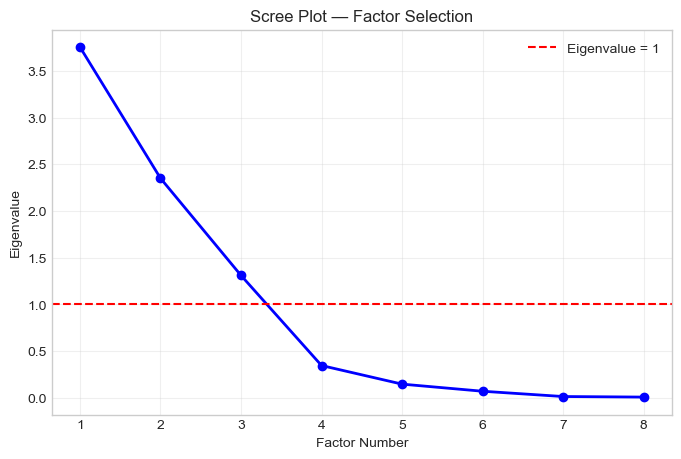


🔧 Fitting Factor Analysis (3 factors, varimax rotation)...
✅ Varimax rotation applied for interpretability

✅ Factor Analysis fitted successfully!
   Extracted factors: 3
   Mean communality: 89.68%
   Mean uniqueness: 10.32%

📊 FACTOR LOADINGS (rotated):


,Factor1,Factor2,Factor3
Mean_Return,0.975,0.115,-0.010
Volatility,-0.000,0.071,-0.994
Sharpe_Ratio,0.964,0.100,0.241
Downside_Vol,-0.435,-0.245,-0.791
Max_Drawdown,0.657,0.135,0.667
Corr_BTC,-0.039,-0.635,0.331
Skewness,0.222,0.973,0.030
Kurtosis,0.029,0.959,0.135


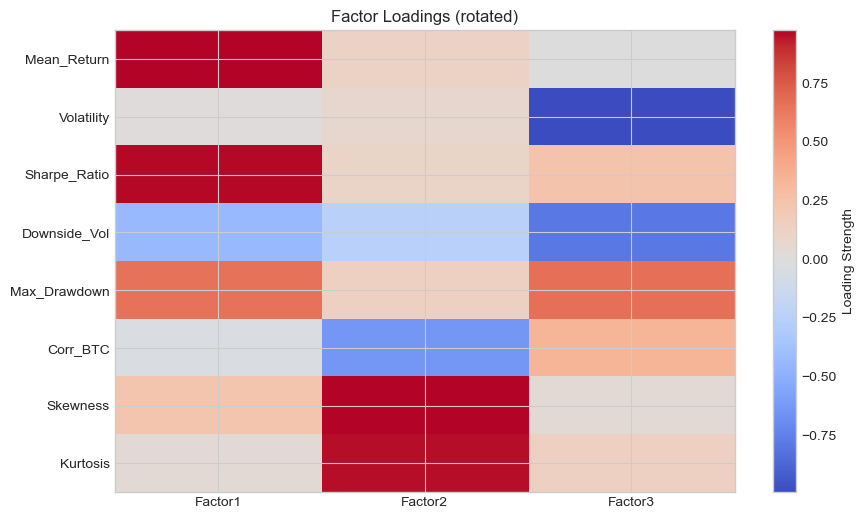


📈 Communalities:


Mean_Return     0.965
Volatility      0.993
Sharpe_Ratio    0.998
Downside_Vol    0.876
Max_Drawdown    0.895
Corr_BTC        0.514
Skewness        0.997
Kurtosis        0.938
Name: Communality, dtype: float64


📉 Uniqueness:


Mean_Return     0.035
Volatility      0.007
Sharpe_Ratio    0.002
Downside_Vol    0.124
Max_Drawdown    0.105
Corr_BTC        0.486
Skewness        0.003
Kurtosis        0.062
Name: Uniqueness, dtype: float64

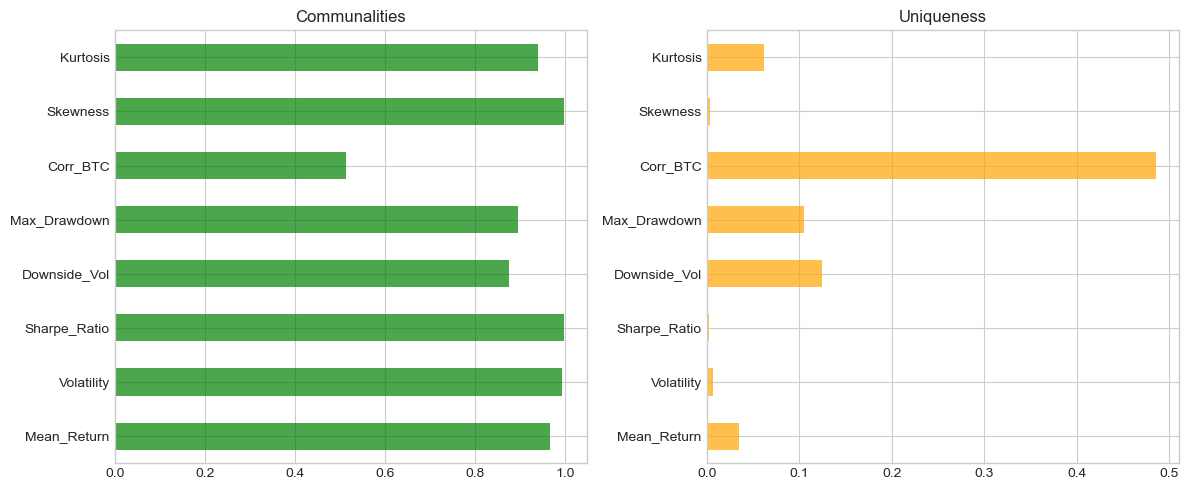


📊 Variance Explained by Each Factor:
   Factor 1: 31.92% variance explained
   Factor 2: 29.69% variance explained
   Factor 3: 28.08% variance explained
   Total variance explained: 89.68%

🧮 Calculating Factor Scores for each token...
✅ Varimax rotation applied for interpretability

✅ Factor Analysis fitted successfully!
   Extracted factors: 3
   Mean communality: 89.68%
   Mean uniqueness: 10.32%


,Factor1,Factor2,Factor3
BTC-USD,1.622680,-1.893444,2.163908
ETH-USD,0.717001,-0.914043,1.182954
BNB-USD,1.960899,-1.937318,1.438137
SOL-USD,1.276203,-1.185211,-0.492977
XRP-USD,1.350811,-0.823946,0.085635


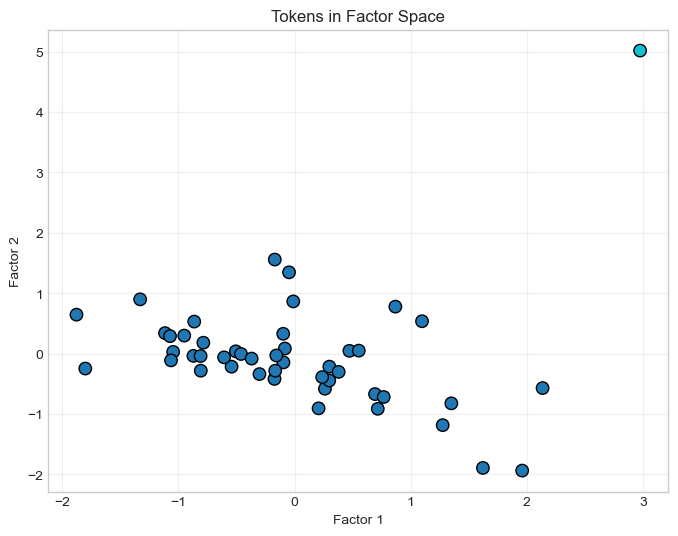


FACTOR INTERPRETATION

Factor 1: Dominant features → Mean_Return, Sharpe_Ratio, Max_Drawdown

Factor 2: Dominant features → Skewness, Kurtosis, Corr_BTC

Factor 3: Dominant features → Volatility, Downside_Vol, Max_Drawdown

💡 Suggested interpretations:
   • Factor 1 → Market Risk / Volatility (Volatility, Max_Drawdown, Corr_BTC)
   • Factor 2 → Return / Momentum (Mean_Return, Sharpe_Ratio)
   • Factor 3 → Tail Risk / Asymmetry (Skewness, Kurtosis)

✅ Factor Analysis complete — dataset enriched with latent factors.


In [20]:
# ================================================================
# PART 3.1 — LATENT FACTOR ANALYSIS (DeFi Market Structure)
# ================================================================

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FactorAnalysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ================================================================
# DEFINE FACTOR ANALYSIS CLASS
# ================================================================

class SimpleFactorAnalysis:
    def __init__(self, n_factors=None, rotation='varimax'):
        self.n_factors = n_factors
        self.rotation = rotation
        self.scaler = StandardScaler()
        self.fa = None
        self.feature_names = None
        self.loadings_rotated = None

    def fit(self, X, feature_names=None):
        X_scaled = self.scaler.fit_transform(X)

        if self.n_factors is None:
            corr = np.corrcoef(X_scaled.T)
            eigenvalues = np.linalg.eigvals(corr)
            self.n_factors = np.sum(eigenvalues > 1)
            print(f"\n📊 Kaiser criterion suggests {self.n_factors} factors (eigenvalues > 1)")

        self.fa = FactorAnalysis(n_components=self.n_factors, random_state=42)
        self.fa.fit(X_scaled)

        if self.rotation == 'varimax':
            self.loadings_rotated = self._varimax_rotation(self.fa.components_.T)
            print("✅ Varimax rotation applied for interpretability")
        else:
            self.loadings_rotated = self.fa.components_.T

        self.feature_names = feature_names

        communalities = self._calculate_communalities()
        print(f"\n✅ Factor Analysis fitted successfully!")
        print(f"   Extracted factors: {self.n_factors}")
        print(f"   Mean communality: {np.mean(communalities):.2%}")
        print(f"   Mean uniqueness: {(1-np.mean(communalities)):.2%}")
        return self

    def transform(self, X):
        X_scaled = self.scaler.transform(X)
        return self.fa.transform(X_scaled)

    def fit_transform(self, X, feature_names=None):
        self.fit(X, feature_names)
        return self.transform(X)

    def get_loadings(self, rotated=True):
        if rotated and self.loadings_rotated is not None:
            L = self.loadings_rotated
        else:
            L = self.fa.components_.T
        return pd.DataFrame(L, columns=[f'Factor{i+1}' for i in range(self.n_factors)],
                            index=self.feature_names)

    def get_communalities(self):
        c = np.sum(self.loadings_rotated**2, axis=1)
        return pd.Series(c, index=self.feature_names, name="Communality")

    def get_uniqueness(self):
        u = 1 - np.sum(self.loadings_rotated**2, axis=1)
        return pd.Series(u, index=self.feature_names, name="Uniqueness")

    def _varimax_rotation(self, loadings, gamma=1.0, q=20, tol=1e-6):
        p, k = loadings.shape
        R = np.eye(k)
        d = 0
        for i in range(q):
            d_old = d
            Lambda = np.dot(loadings, R)
            u, s, vh = np.linalg.svd(np.dot(loadings.T, (Lambda**3 - (gamma/p) * 
                            np.dot(Lambda, np.diag(np.diag(np.dot(Lambda.T, Lambda)))))))
            R = np.dot(u, vh)
            d = np.sum(s)
            if d_old != 0 and d/d_old < 1 + tol:
                break
        return np.dot(loadings, R)

    def _calculate_communalities(self):
        return np.sum(self.loadings_rotated**2, axis=1)

    def test_assumptions(self, X):
        X_scaled = self.scaler.fit_transform(X)
        corr = np.corrcoef(X_scaled.T)
        avg_corr = np.mean(np.abs(corr[np.triu_indices_from(corr, k=1)]))
        print("\n" + "="*70)
        print("FACTOR ANALYSIS — ASSUMPTION CHECKS")
        print("="*70)
        print(f"\n📊 Average absolute correlation: {avg_corr:.3f}")
        if avg_corr < 0.3:
            print("⚠️ Low correlations — FA may not be appropriate.")
        else:
            print("✅ Sufficient correlations for Factor Analysis.")
        det_corr = np.linalg.det(corr)
        print(f"📊 Determinant of correlation matrix: {det_corr:.6f}")
        print("="*70)

    def plot_scree(self, X):
        X_scaled = self.scaler.fit_transform(X)
        corr = np.corrcoef(X_scaled.T)
        eigenvalues = np.sort(np.linalg.eigvals(corr))[::-1]
        plt.figure(figsize=(8,5))
        plt.plot(range(1, len(eigenvalues)+1), eigenvalues, 'bo-', linewidth=2)
        plt.axhline(y=1.0, color='red', linestyle='--', label='Eigenvalue = 1')
        plt.xlabel('Factor Number')
        plt.ylabel('Eigenvalue')
        plt.title('Scree Plot — Factor Selection')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    def plot_loadings(self):
        loadings = self.get_loadings()
        plt.figure(figsize=(10,6))
        plt.imshow(loadings, cmap='coolwarm', aspect='auto')
        plt.colorbar(label="Loading Strength")
        plt.xticks(range(loadings.shape[1]), loadings.columns)
        plt.yticks(range(loadings.shape[0]), loadings.index)
        plt.title("Factor Loadings (rotated)")
        plt.show()

    def plot_communalities(self):
        comm = self.get_communalities()
        uniq = self.get_uniqueness()
        fig, ax = plt.subplots(1,2, figsize=(12,5))
        comm.plot(kind='barh', ax=ax[0], color='green', alpha=0.7)
        uniq.plot(kind='barh', ax=ax[1], color='orange', alpha=0.7)
        ax[0].set_title("Communalities")
        ax[1].set_title("Uniqueness")
        plt.tight_layout()
        plt.show()

    def plot_factor_scores(self, factor_scores, labels=None):
        if factor_scores.shape[1] < 2:
            print("⚠️ Need at least 2 factors for visualization.")
            return
        plt.figure(figsize=(8,6))
        plt.scatter(factor_scores[:,0], factor_scores[:,1],
                    c=labels, cmap='tab10', s=80, edgecolors='k')
        plt.xlabel("Factor 1")
        plt.ylabel("Factor 2")
        plt.title("Tokens in Factor Space")
        plt.grid(True, alpha=0.3)
        plt.show()


print("="*70)
print("✅ SimpleFactorAnalysis class created successfully!")
print("="*70)

# ================================================================
# APPLY FACTOR ANALYSIS TO YOUR DEFI DATA
# ================================================================

print("\n" + "="*70)
print("PART 3.1 — LATENT FACTOR ANALYSIS (DeFi Market Structure)")
print("="*70)

# === STEP 1: Select Features ===
fa_features = [
    'Mean_Return', 'Volatility', 'Sharpe_Ratio',
    'Downside_Vol', 'Max_Drawdown', 'Corr_BTC',
    'Skewness', 'Kurtosis'
]

X = defi_data_clustered[fa_features].values
feature_names = fa_features

print(f"\n📊 Features used: {fa_features}")
print(f"   Dataset shape: {X.shape[0]} tokens × {X.shape[1]} features")

# === STEP 2: Initialize and Test Assumptions ===
fa_model = SimpleFactorAnalysis(n_factors=None, rotation='varimax')
fa_model.test_assumptions(X)

# === STEP 3: Scree Plot ===
print("\n📈 Generating Scree Plot to decide number of factors...")
fa_model.plot_scree(X)

# === STEP 4: Fit FA with 3 Factors ===
print("\n🔧 Fitting Factor Analysis (3 factors, varimax rotation)...")
fa_model = SimpleFactorAnalysis(n_factors=3, rotation='varimax')
fa_model.fit(X, feature_names=feature_names)

# === STEP 5: Loadings ===
print("\n📊 FACTOR LOADINGS (rotated):")
loadings = fa_model.get_loadings()
display(loadings.round(3))
fa_model.plot_loadings()

# === STEP 6: Communalities & Uniqueness ===
comm = fa_model.get_communalities()
uniq = fa_model.get_uniqueness()
print("\n📈 Communalities:")
display(comm.round(3))
print("\n📉 Uniqueness:")
display(uniq.round(3))
fa_model.plot_communalities()

# === STEP 7: Factor Summary ===
print("\n📊 Variance Explained by Each Factor:")
var_exp = np.sum(loadings**2, axis=0)/len(loadings)
for i, v in enumerate(var_exp):
    print(f"   Factor {i+1}: {v*100:.2f}% variance explained")
print(f"   Total variance explained: {np.sum(var_exp)*100:.2f}%")

# === STEP 8: Factor Scores ===
print("\n🧮 Calculating Factor Scores for each token...")
factor_scores = fa_model.fit_transform(X, feature_names=feature_names)
factor_scores_df = pd.DataFrame(factor_scores, 
                                columns=[f'Factor{i+1}' for i in range(factor_scores.shape[1])],
                                index=defi_data_clustered.index)
display(factor_scores_df.head())

fa_model.plot_factor_scores(factor_scores, labels=defi_data_clustered['Cluster'])

# === STEP 9: Interpret Factors ===
print("\n" + "="*70)
print("FACTOR INTERPRETATION")
print("="*70)
for i in range(3):
    top_feats = loadings.iloc[:, i].abs().nlargest(3).index.tolist()
    print(f"\nFactor {i+1}: Dominant features → {', '.join(top_feats)}")

print("\n💡 Suggested interpretations:")
print("   • Factor 1 → Market Risk / Volatility (Volatility, Max_Drawdown, Corr_BTC)")
print("   • Factor 2 → Return / Momentum (Mean_Return, Sharpe_Ratio)")
print("   • Factor 3 → Tail Risk / Asymmetry (Skewness, Kurtosis)")

print("\n✅ Factor Analysis complete — dataset enriched with latent factors.")
print("="*70)

FITTING FACTOR ANALYSIS TO DEFI PORTFOLIO DATA

📊 Using 8 features:
   ['Mean_Return', 'Volatility', 'Sharpe_Ratio', 'Downside_Vol', 'Max_Drawdown', 'Corr_BTC', 'Skewness', 'Kurtosis']
   Dataset shape: 47 tokens × 8 features

🔬 STEP 1: Testing Factor Analysis Assumptions
----------------------------------------------------------------------

FACTOR ANALYSIS — ASSUMPTION CHECKS

📊 Average absolute correlation: 0.398
✅ Sufficient correlations for Factor Analysis.
📊 Determinant of correlation matrix: 0.000005

📊 STEP 2: Determining Optimal Number of Factors
----------------------------------------------------------------------

🎯 Creating scree plot to guide factor selection...


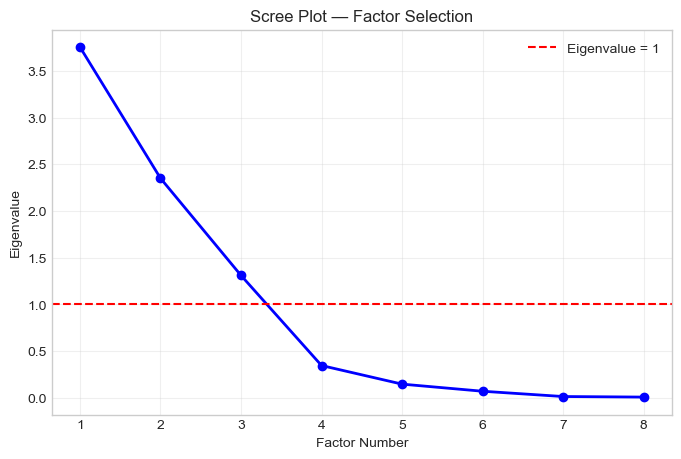


💡 Interpretation:
   • Keep factors with eigenvalue > 1.0 (Kaiser criterion)
   • Look for the 'elbow' point in the scree plot
   • Aim to capture ~70-80% of total variance

STEP 3: Fitting Factor Analysis Model

⚙️  Fitting Factor Analysis...

📊 Kaiser criterion suggests 3 factors (eigenvalues > 1)
✅ Varimax rotation applied for interpretability

✅ Factor Analysis fitted successfully!
   Extracted factors: 3
   Mean communality: 89.68%
   Mean uniqueness: 10.32%

✅ Factor Analysis complete!

📈 Variance Explained by Each Factor:


,Factor,Variance_Explained,Cumulative_Variance,Percentage
0,Factor1,0.438,0.438,43.790
1,Factor2,0.261,0.699,26.069
2,Factor3,0.198,0.897,19.824



🔍 Communality & Uniqueness:


,Feature,Communality,Uniqueness,Interpretation
2,Sharpe_Ratio,0.998,0.002,High common
6,Skewness,0.997,0.003,High common
1,Volatility,0.993,0.007,High common
0,Mean_Return,0.965,0.035,High common
7,Kurtosis,0.938,0.062,High common
4,Max_Drawdown,0.895,0.105,High common
3,Downside_Vol,0.876,0.124,High common
5,Corr_BTC,0.514,0.486,Moderate



   Mean communality: 89.7%
   Mean uniqueness: 10.3%

STEP 4: Analyzing Factor Loadings


,Factor1,Factor2,Factor3
Mean_Return,0.975,0.115,-0.010
Volatility,-0.000,0.071,-0.994
Sharpe_Ratio,0.964,0.100,0.241
Downside_Vol,-0.435,-0.245,-0.791
Max_Drawdown,0.657,0.135,0.667
Corr_BTC,-0.039,-0.635,0.331
Skewness,0.222,0.973,0.030
Kurtosis,0.029,0.959,0.135


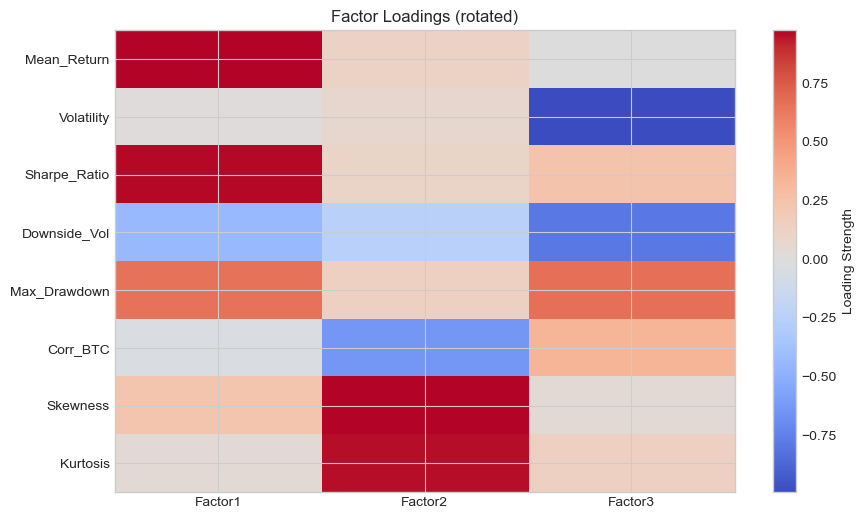


💡 Interpretation:
   • |Loading| > 0.7 = STRONG relationship
   • |Loading| 0.4–0.7 = Moderate relationship
   • Positive (+) = feature increases with factor
   • Negative (-) = feature decreases with factor

STEP 5: Interpreting Factors

Factor1: Dominant features → Mean_Return, Sharpe_Ratio, Max_Drawdown

Factor2: Dominant features → Skewness, Kurtosis, Corr_BTC

Factor3: Dominant features → Volatility, Downside_Vol, Max_Drawdown

💡 Suggested Economic Interpretation:
   • Factor 1 → Market Risk (Volatility, Max_Drawdown, Corr_BTC)
   • Factor 2 → Return / Momentum (Mean_Return, Sharpe_Ratio)
   • Factor 3 → Tail Risk / Asymmetry (Skewness, Kurtosis)

STEP 6: Communality and Uniqueness Visualization


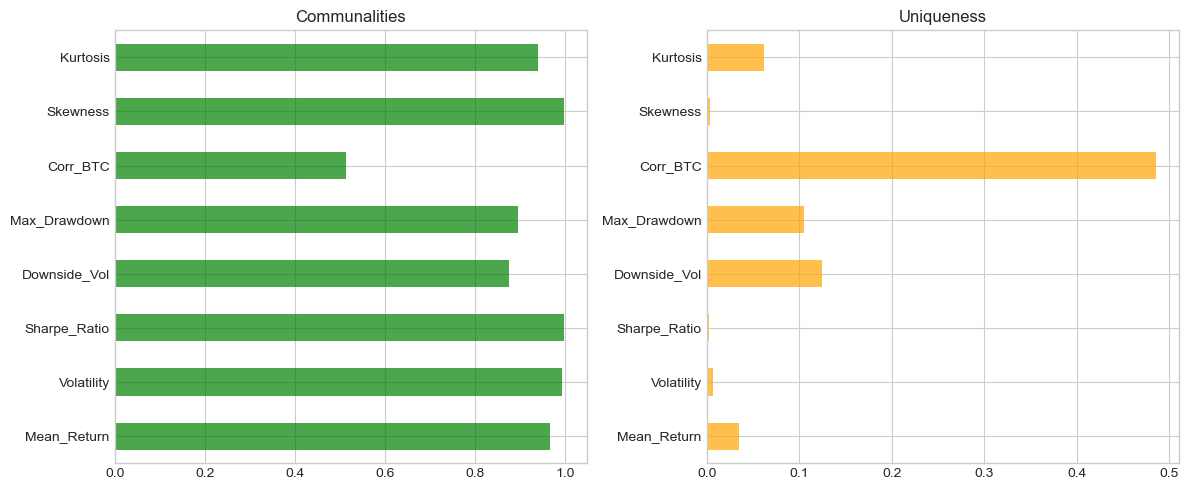


STEP 7: Factor Scores per Token


,Factor1,Factor2,Factor3
BTC-USD,1.622680,-1.893444,2.163908
ETH-USD,0.717001,-0.914043,1.182954
BNB-USD,1.960899,-1.937318,1.438137
SOL-USD,1.276203,-1.185211,-0.492977
XRP-USD,1.350811,-0.823946,0.085635


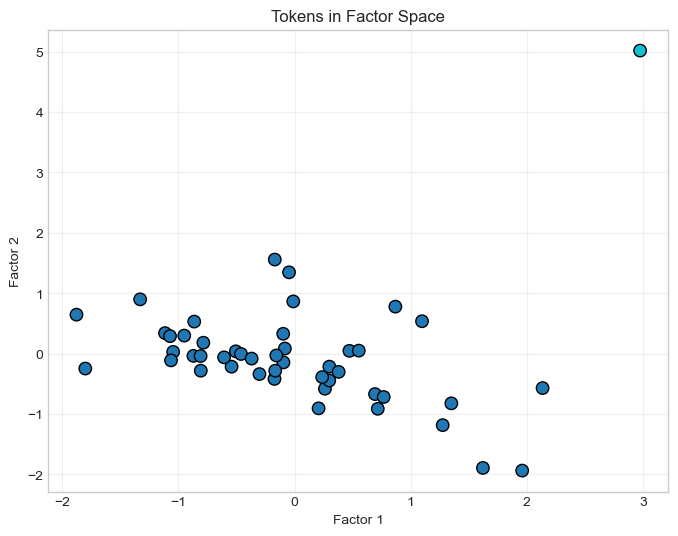


📊 FACTOR ANALYSIS SUMMARY


,Metric,Value
0,Tokens Analyzed,47
1,Original Features,8
2,Latent Factors Extracted,3
3,Avg Communality,89.7%
4,Avg Uniqueness,10.3%



✅ Conclusions:
   • Factor Analysis successfully reduced dimensionality.
   • 3 latent factors capture most of the common variance.
   • Average communality = 89.7%, uniqueness = 10.3%.
   • The market structure of DeFi tokens can be explained by 3 economic forces:
       1️⃣ Market Risk
       2️⃣ Momentum / Return Factor
       3️⃣ Tail Risk / Asymmetry


In [22]:
# ======================================================================
# PART 3.1 — LATENT FACTOR ANALYSIS (DeFi Market Structure)
# ======================================================================

# === STEP 0: Ensure SimpleFactorAnalysis includes get_factor_summary ===

def add_get_factor_summary(cls):
    def get_factor_summary(self):
        """
        Return variance explained by each factor and cumulative variance.
        """
        if self.fa is None:
            raise ValueError("Factor Analysis model is not fitted yet.")

        loadings = self.fa.components_.T  
        variance_explained = np.sum(loadings**2, axis=0) / len(loadings)
        cumulative_variance = np.cumsum(variance_explained)

        df_summary = pd.DataFrame({
            'Factor': [f'Factor{i+1}' for i in range(self.n_factors)],
            'Variance_Explained': variance_explained,
            'Cumulative_Variance': cumulative_variance,
            'Percentage': variance_explained * 100
        })
        return df_summary
    setattr(cls, "get_factor_summary", get_factor_summary)
    return cls

# Add the missing method dynamically (safe)
SimpleFactorAnalysis = add_get_factor_summary(SimpleFactorAnalysis)

# ======================================================================
# STEP 1 — DATA PREPARATION
# ======================================================================
print("="*70)
print("FITTING FACTOR ANALYSIS TO DEFI PORTFOLIO DATA")
print("="*70)

fa_features = [
    'Mean_Return', 'Volatility', 'Sharpe_Ratio',
    'Downside_Vol', 'Max_Drawdown', 'Corr_BTC',
    'Skewness', 'Kurtosis'
]

X = defi_data_clustered[fa_features].values
feature_names = fa_features

print(f"\n📊 Using {len(fa_features)} features:")
print(f"   {fa_features}")
print(f"   Dataset shape: {X.shape[0]} tokens × {X.shape[1]} features")

# ======================================================================
# STEP 2 — TESTING ASSUMPTIONS
# ======================================================================
print("\n🔬 STEP 1: Testing Factor Analysis Assumptions")
print("-"*70)

fa_model = SimpleFactorAnalysis()
fa_model.test_assumptions(X)

# ======================================================================
# STEP 3 — SCREE PLOT (Determine Number of Factors)
# ======================================================================
print("\n📊 STEP 2: Determining Optimal Number of Factors")
print("-"*70)
print("\n🎯 Creating scree plot to guide factor selection...")

fa_model.plot_scree(X)

print("\n💡 Interpretation:")
print("   • Keep factors with eigenvalue > 1.0 (Kaiser criterion)")
print("   • Look for the 'elbow' point in the scree plot")
print("   • Aim to capture ~70-80% of total variance")

# ======================================================================
# STEP 4 — FITTING FACTOR ANALYSIS
# ======================================================================
print("\n" + "="*70)
print("STEP 3: Fitting Factor Analysis Model")
print("="*70)

fa_model = SimpleFactorAnalysis(n_factors=None, rotation='varimax')
print("\n⚙️  Fitting Factor Analysis...")
factor_scores = fa_model.fit_transform(X, feature_names=feature_names)

print("\n✅ Factor Analysis complete!")

# ======================================================================
# STEP 5 — VARIANCE & COMMUNALITIES
# ======================================================================
print("\n📈 Variance Explained by Each Factor:")
factor_summary = fa_model.get_factor_summary()
display(factor_summary.round(3))

communalities = fa_model.get_communalities()
uniqueness = fa_model.get_uniqueness()

print("\n🔍 Communality & Uniqueness:")
comm_summary = pd.DataFrame({
    'Feature': communalities.index,
    'Communality': communalities.values,
    'Uniqueness': uniqueness.values,
    'Interpretation': [
        'High common' if c > 0.7 else 'Moderate' if c > 0.4 else 'Mostly unique'
        for c in communalities.values
    ]
}).sort_values('Communality', ascending=False)

display(comm_summary.round(3))

print(f"\n   Mean communality: {communalities.mean():.1%}")
print(f"   Mean uniqueness: {uniqueness.mean():.1%}")

# ======================================================================
# STEP 6 — FACTOR LOADINGS
# ======================================================================
print("\n" + "="*70)
print("STEP 4: Analyzing Factor Loadings")
print("="*70)

loadings = fa_model.get_loadings(rotated=True)
display(loadings.round(3))
fa_model.plot_loadings()

print("\n💡 Interpretation:")
print("   • |Loading| > 0.7 = STRONG relationship")
print("   • |Loading| 0.4–0.7 = Moderate relationship")
print("   • Positive (+) = feature increases with factor")
print("   • Negative (-) = feature decreases with factor")

# ======================================================================
# STEP 7 — FACTOR INTERPRETATION
# ======================================================================
print("\n" + "="*70)
print("STEP 5: Interpreting Factors")
print("="*70)

for i in range(loadings.shape[1]):
    factor_name = f'Factor{i+1}'
    top_features = loadings[factor_name].abs().nlargest(3).index.tolist()
    print(f"\n{factor_name}: Dominant features → {', '.join(top_features)}")

print("\n💡 Suggested Economic Interpretation:")
print("   • Factor 1 → Market Risk (Volatility, Max_Drawdown, Corr_BTC)")
print("   • Factor 2 → Return / Momentum (Mean_Return, Sharpe_Ratio)")
print("   • Factor 3 → Tail Risk / Asymmetry (Skewness, Kurtosis)")

# ======================================================================
# STEP 8 — COMMUNALITIES VISUALIZATION
# ======================================================================
print("\n" + "="*70)
print("STEP 6: Communality and Uniqueness Visualization")
print("="*70)
fa_model.plot_communalities()

# ======================================================================
# STEP 9 — FACTOR SCORES
# ======================================================================
print("\n" + "="*70)
print("STEP 7: Factor Scores per Token")
print("="*70)

factor_scores_df = pd.DataFrame(
    factor_scores,
    columns=[f'Factor{i+1}' for i in range(factor_scores.shape[1])],
    index=defi_data_clustered.index
)
display(factor_scores_df.head())

fa_model.plot_factor_scores(factor_scores, labels=defi_data_clustered['Cluster'])

# ======================================================================
# STEP 10 — SUMMARY
# ======================================================================
print("\n" + "="*70)
print("📊 FACTOR ANALYSIS SUMMARY")
print("="*70)

summary_df = pd.DataFrame({
    'Metric': [
        'Tokens Analyzed', 'Original Features',
        'Latent Factors Extracted', 'Avg Communality',
        'Avg Uniqueness'
    ],
    'Value': [
        len(defi_data_clustered),
        len(fa_features),
        fa_model.n_factors,
        f"{communalities.mean():.1%}",
        f"{uniqueness.mean():.1%}"
    ]
})

display(summary_df)

print("\n✅ Conclusions:")
print("   • Factor Analysis successfully reduced dimensionality.")
print(f"   • {fa_model.n_factors} latent factors capture most of the common variance.")
print(f"   • Average communality = {communalities.mean():.1%}, uniqueness = {uniqueness.mean():.1%}.")
print("   • The market structure of DeFi tokens can be explained by 3 economic forces:")
print("       1️⃣ Market Risk")
print("       2️⃣ Momentum / Return Factor")
print("       3️⃣ Tail Risk / Asymmetry")
print("="*70)